# Table of Content
## 1. Data cleaning and Exploration
### 1.1 Importing the libraries and dataset
### 1.2 Basic statistics and data quality inspection
### 1.3 Handling the categorical variables
### 1.4 Handling the numeric variables
## 2. Feature Engineering
### 2.1 Exctracting valuable information from Dates
### 2.2 Creating variable Season
## 3. Categorical data transformation before modelling
## 4. Modelling
### 4.1 Logistic Regression as Baseline Model 
### 4.2 Logistic Regression with imputation of incorrect numeric values by Iterative Imputer 
### 4.3 Features selection (as part of modelling process)
####  4.3.1 Removing features with low variance
#### 4.3.2 Univariate feature selection with ANOVA test
#### 4.3.3 Logistic Regression with regularization (Lasso/Ridge)
### 4.4 SVM (Support Vector Machines)
### 4.5 KNN (K Nearest Neighbors)
### 4.6 Tree-Based models and their optimization
#### 4.6.1 Decision Tree
#### 4.6.2 Random Forest
#### 4.6.3 Light GBM
## 5 Ensembling the best models using MaxVoting and Stacking techniques
### 5.1 MaxVoting
### 5.2 Stacking
## 6 Models comparison and best prediction
## 7 Wrap-up

















For the assignment we have used data from Taarifa waterpoints dashboard, which aggregates data from the Tanzania Ministry of Water. The main goal is to predict which pumps are functional, which need some repairs, and which don't work at all. This data is hosted by "drivendata.org". The prediction of these three classes is based on a number of variables about  what kind of pump is operating, when it was installed, and how it is managed. 

We have been provided with four different Files:
    [1]Submission Format: The format for submitting our predictions
    [2]Test set values: The independent variables that need predictions
    [3]Training set labels: The dependent variable (status_group) for each of 
        the rows in Training set values
    [4]Training set values: The independent variables for the training set

First of all, we have taken a look at what kind of information is provided about the waterpoints:

# 1. Data cleaning and Exploration

## 1.1 Importing libraries and dataset

In [2]:
#setting the seed for reproducability
import random
random.seed(444)

In [2]:
#importing the necessary libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline
import warnings
warnings.filterwarnings("ignore")
from IPython.display import Image

In [3]:
#seeting the number of displayed columns and rows
pd.set_option('display.max_columns', 100)
pd.set_option('display.max_rows', 100)

In [3]:
#loading the dataset 
df_train = pd.read_csv ('https://s3.amazonaws.com/drivendata/data/7/public/4910797b-ee55-40a7-8668-10efd5c1b960.csv', sep=',')
df_test = pd.read_csv ('https://s3.amazonaws.com/drivendata/data/7/public/702ddfc5-68cd-4d1d-a0de-f5f566f76d91.csv', sep=',')

In [5]:
df_train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 59400 entries, 0 to 59399
Data columns (total 40 columns):
id                       59400 non-null int64
amount_tsh               59400 non-null float64
date_recorded            59400 non-null object
funder                   55765 non-null object
gps_height               59400 non-null int64
installer                55745 non-null object
longitude                59400 non-null float64
latitude                 59400 non-null float64
wpt_name                 59400 non-null object
num_private              59400 non-null int64
basin                    59400 non-null object
subvillage               59029 non-null object
region                   59400 non-null object
region_code              59400 non-null int64
district_code            59400 non-null int64
lga                      59400 non-null object
ward                     59400 non-null object
population               59400 non-null int64
public_meeting           56066 non-null object
r

In [6]:
df_test.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 14850 entries, 0 to 14849
Data columns (total 40 columns):
id                       14850 non-null int64
amount_tsh               14850 non-null float64
date_recorded            14850 non-null object
funder                   13981 non-null object
gps_height               14850 non-null int64
installer                13973 non-null object
longitude                14850 non-null float64
latitude                 14850 non-null float64
wpt_name                 14850 non-null object
num_private              14850 non-null int64
basin                    14850 non-null object
subvillage               14751 non-null object
region                   14850 non-null object
region_code              14850 non-null int64
district_code            14850 non-null int64
lga                      14850 non-null object
ward                     14850 non-null object
population               14850 non-null int64
public_meeting           14029 non-null object
r

In [6]:
target = pd.read_csv ('https://s3.amazonaws.com/drivendata/data/7/public/0bf8bc6e-30d0-4c50-956a-603fc693d966.csv', sep=',')

In [7]:
target.head()

,id,status_group
0,69572,functional
1,8776,functional
2,34310,functional
3,67743,non functional
4,19728,functional


In [8]:
#merging the databases and checking the shape
df_train_full=pd.merge(df_train, target[['id','status_group']], on='id'); df_train_full.shape

(59400, 41)

In [9]:
#creating Target variable in test set in order in merge databases for EDA
df_test['status_group']=df_test.apply(lambda _: '', axis=1)

In [11]:
#merging the databases and checking the shape
df=pd.concat([df_train_full, df_test]); df.shape

(74250, 41)

## 1.2 Basic statistics and data quality inspection

First of all, we are going to take a look at the datatypes of each column and we can see that we have some features which have to be transformed

### Setting proper data types

In [12]:
#looks like we have to change datatypes for some variable here
df.dtypes

id                         int64
amount_tsh               float64
date_recorded             object
funder                    object
gps_height                 int64
installer                 object
longitude                float64
latitude                 float64
wpt_name                  object
num_private                int64
basin                     object
subvillage                object
region                    object
region_code                int64
district_code              int64
lga                       object
ward                      object
population                 int64
public_meeting            object
recorded_by               object
scheme_management         object
scheme_name               object
permit                    object
construction_year          int64
extraction_type           object
extraction_type_group     object
extraction_type_class     object
management                object
management_group          object
payment                   object
payment_ty

In [13]:
# Setting proper data types
# date time conversion
df["date_recorded"] = pd.to_datetime(df.date_recorded)

# The following variables should be categorical, but they set as numeric
df["id"] = df.id.astype("object")
df["num_private"] = df.num_private.astype("object")
df["region_code"] = df.region_code.astype("object")
df["district_code"] = df.district_code.astype("object")

In [14]:
df.columns

Index(['id', 'amount_tsh', 'date_recorded', 'funder', 'gps_height',
       'installer', 'longitude', 'latitude', 'wpt_name', 'num_private',
       'basin', 'subvillage', 'region', 'region_code', 'district_code', 'lga',
       'ward', 'population', 'public_meeting', 'recorded_by',
       'scheme_management', 'scheme_name', 'permit', 'construction_year',
       'extraction_type', 'extraction_type_group', 'extraction_type_class',
       'management', 'management_group', 'payment', 'payment_type',
       'water_quality', 'quality_group', 'quantity', 'quantity_group',
       'source', 'source_type', 'source_class', 'waterpoint_type',
       'waterpoint_type_group', 'status_group'],
      dtype='object')

### Creating variable Train/Test split

In [15]:
# Creating the column, which would be responsible for Train and Test sample separate tracking 
df['set'] =''
df['set'].iloc[0:59400,] = df['set'].iloc[0:59400,].apply(lambda X: 'Training')
df['set'].iloc[59400:,] = df['set'].iloc[59400:,].apply(lambda X: 'Test')

In [17]:
df['set'] = df.set.astype("object")
df['set'].value_counts()

Training    59400
Test        14850
Name: set, dtype: int64

### Checking for duplicates

In [17]:
#Finding the identical rows.
dupes=df.duplicated()
sum(dupes)
#No duplicates were recorded

0

### Checking missing values

In [18]:
100*df.isnull().sum()/df.isnull().count()

id                        0.000000
amount_tsh                0.000000
date_recorded             0.000000
funder                    6.065993
gps_height                0.000000
installer                 6.103704
longitude                 0.000000
latitude                  0.000000
wpt_name                  0.000000
num_private               0.000000
basin                     0.000000
subvillage                0.632997
region                    0.000000
region_code               0.000000
district_code             0.000000
lga                       0.000000
ward                      0.000000
population                0.000000
public_meeting            5.595960
recorded_by               0.000000
scheme_management         6.526599
scheme_name              47.485522
permit                    5.108418
construction_year         0.000000
extraction_type           0.000000
extraction_type_group     0.000000
extraction_type_class     0.000000
management                0.000000
management_group    

In [19]:
#We will drop the columns with 30%+ of missing values, because we can not deal with such a huge amount for imputation
col_to_drop=df.columns[100*df.isnull().sum()/df.isnull().count()>30]; col_to_drop

Index(['scheme_name'], dtype='object')

In [20]:
#Dropping it
df=df.drop(columns=col_to_drop, axis=1) 

### Removing variables with constant values and high cardinality

In [21]:
#Getting columns with constant values
df.columns[df.nunique()==1]

Index(['recorded_by'], dtype='object')

In [22]:
#And dropping it
df.drop(['recorded_by'], axis = 1, inplace = True) 

In [23]:
#number of rows
nrows=len(df)
#Getting columns with 50% of the base unique values
df.columns[df.nunique()>nrows*0.5]

Index(['id', 'longitude', 'latitude', 'wpt_name'], dtype='object')

In [24]:
#We will drop the id and wpt_name since the id - is just an identification number 
#While for wpt_name the level of detail/granularity is very high. And literraly, it is just a WaterPoint name (so it is absolutely useless to dummify this variable)
df.drop(['id', 'wpt_name'], axis = 1, inplace = True) 

## 1.3 Handling the categorical variables

In [25]:
# Getting the missing values for categorical data only
df.select_dtypes(include=["object"]).isna().sum().sort_values(ascending=False)

scheme_management        4846
installer                4532
funder                   4504
public_meeting           4155
permit                   3793
subvillage                470
extraction_type_group       0
num_private                 0
basin                       0
region                      0
region_code                 0
district_code               0
lga                         0
ward                        0
extraction_type             0
set                         0
status_group                0
management                  0
management_group            0
payment                     0
payment_type                0
water_quality               0
quality_group               0
quantity                    0
quantity_group              0
source                      0
source_type                 0
source_class                0
waterpoint_type             0
waterpoint_type_group       0
extraction_type_class       0
dtype: int64

In [26]:
# We will replace missing values with 'No information'
for col in ['scheme_management', 'installer', 'funder', 'public_meeting', 'permit', 'subvillage']:
    df[col].fillna('No information', inplace=True)

In [27]:
# Getting the categorical variables with a lot of levels
df.select_dtypes(include=["object"]).nunique().sort_values(ascending=False)

subvillage               21426
installer                 2411
funder                    2141
ward                      2098
lga                        125
num_private                 68
region_code                 27
region                      21
district_code               20
extraction_type             18
extraction_type_group       13
scheme_management           13
management                  12
source                      10
basin                        9
water_quality                8
extraction_type_class        7
payment                      7
payment_type                 7
source_type                  7
waterpoint_type              7
quality_group                6
waterpoint_type_group        6
management_group             5
quantity                     5
quantity_group               5
status_group                 4
permit                       3
public_meeting               3
source_class                 3
set                          2
dtype: int64

We should check and try to reduce the number of categories for the following variables

subvillage               21426
installer                 2411
funder                    2141
ward                      2098

In [28]:
#Checking 'subvillage' levels .
df['subvillage'].value_counts()

Shuleni                 646
Majengo                 631
Madukani                629
No information          470
Kati                    467
Mtakuja                 322
Sokoni                  294
M                       243
Muungano                215
Mbuyuni                 210
Songambele              194
Mlimani                 190
Miembeni                168
Msikitini               164
1                       157
Kanisani                146
Kibaoni                 143
Mjini                   131
Mjimwema                129
Mapinduzi               126
Mkwajuni                125
Mwenge                  125
I                       124
Bondeni                 121
Azimio                  116
Amani                   115
Mabatini                114
Mbugani                 113
Senta                   111
Mission                 110
Kichangani              110
Mtaa Wa Kitunda Kati    108
Chang'Ombe              108
Zahanati                104
Bwawani                 103
Nyerere             

In [29]:
#We can drop the Subvillage since it is just the name of the village. 
df.drop(['subvillage'], axis = 1, inplace = True) 

We will analyse other variables step by step

In [30]:
#Checking 'installer' levels .
df['installer'].value_counts()

DWE                           21751
No information                 4532
Government                     2282
RWE                            1498
Commu                          1347
DANIDA                         1305
KKKT                           1120
Hesawa                         1070
0                               980
TCRS                            887
CES                             765
Central government              764
DANID                           690
Community                       687
HESAWA                          679
District Council                663
World vision                    517
TASAF                           504
LGA                             501
WEDECO                          496
District council                490
Gover                           483
AMREF                           398
TWESA                           395
WU                              377
Dmdd                            356
ACRA                            346
World Vision                

In [31]:
# We see that the variable has zero values. We will replace zeros with 'No information' as well
df.loc[df['installer'] == '0','installer'] = 'No information'

In [32]:
# We will categorize the variants with less than 500 frequency:
for col in ['installer']:
    val = df[col].value_counts(normalize=False, sort=True, ascending=False)
    val_rares0 = [k for k in val.keys() if val[k]<10]
    if len(val_rares0)>0:
        df.loc[df[col].isin(val_rares0),col] = col+'Tiny fraction'   
    val_rares1 = [k for k in val.keys() if val[k]>=10 and val[k]<50]
    if len(val_rares1)>0:
        df.loc[df[col].isin(val_rares1),col] = col+'Very rare'  
    val_rares2 = [k for k in val.keys() if val[k]>=50 and val[k]<150]
    if len(val_rares2)>0:
        df.loc[df[col].isin(val_rares2),col] = col+'Rare' 
    val_rares3 = [k for k in val.keys() if val[k]>=150 and val[k]<250]
    if len(val_rares3)>0:
        df.loc[df[col].isin(val_rares3),col] = col+'Quite Rare'     
    val_rares4 = [k for k in val.keys() if val[k]>=250 and val[k]<500]
    if len(val_rares4)>0:
        df.loc[df[col].isin(val_rares4),col] = col+'Not Rare'  

In [33]:
#Checking 'funder' levels 
df['funder'].value_counts()

Government Of Tanzania            11299
No information                     4504
Danida                             3907
Hesawa                             2782
Rwssp                              1703
World Bank                         1701
Kkkt                               1623
World Vision                       1562
Unicef                             1324
Tasaf                              1136
Dhv                                1065
District Council                   1037
Private Individual                 1034
Dwsp                               1012
0                                   980
Norad                               949
Germany Republi                     765
Water                               739
Tcrs                                735
Ministry Of Water                   728
Dwe                                 605
Netherlands                         592
Hifab                               577
Adb                                 551
Lga                                 546


In [34]:
# Replacing zeros with 'No information' as well
df.loc[df['funder'] == '0','funder'] = 'No information'

In [35]:
#Checking 'funder' levels 
df['funder'].value_counts()

Government Of Tanzania            11299
No information                     5484
Danida                             3907
Hesawa                             2782
Rwssp                              1703
World Bank                         1701
Kkkt                               1623
World Vision                       1562
Unicef                             1324
Tasaf                              1136
Dhv                                1065
District Council                   1037
Private Individual                 1034
Dwsp                               1012
Norad                               949
Germany Republi                     765
Water                               739
Tcrs                                735
Ministry Of Water                   728
Dwe                                 605
Netherlands                         592
Hifab                               577
Adb                                 551
Lga                                 546
Amref                               525


In [36]:
# We will categorize the variants with less than 700 frequency:
for col in ['funder']:
    val = df[col].value_counts(normalize=False, sort=True, ascending=False)
    val_rares0 = [k for k in val.keys() if val[k]<50]
    if len(val_rares0)>0:
        df.loc[df[col].isin(val_rares0),col] = col+'Tiny fraction'      
    val_rares1 = [k for k in val.keys() if val[k]>=50 and val[k]<200]
    if len(val_rares1)>0:
        df.loc[df[col].isin(val_rares1),col] = col+'Very rare'  
    val_rares2 = [k for k in val.keys() if val[k]>=200 and val[k]<300]
    if len(val_rares2)>0:
        df.loc[df[col].isin(val_rares2),col] = col+'Quite rare' 
    val_rares3 = [k for k in val.keys() if val[k]>=300 and val[k]<500]
    if len(val_rares3)>0:
        df.loc[df[col].isin(val_rares3),col] = col+'Rare'     
    val_rares4 = [k for k in val.keys() if val[k]>=500 and val[k]<700]
    if len(val_rares4)>0:
        df.loc[df[col].isin(val_rares4),col] = col+'Not Rare'  

In [37]:
#Checking 'funder' levels 
df['funder'].value_counts()

Government Of Tanzania    11299
funderVery rare           10828
funderTiny fraction        9833
funderRare                 5870
No information             5484
Danida                     3907
funderQuite rare           3738
funderNot Rare             3396
Hesawa                     2782
Rwssp                      1703
World Bank                 1701
Kkkt                       1623
World Vision               1562
Unicef                     1324
Tasaf                      1136
Dhv                        1065
District Council           1037
Private Individual         1034
Dwsp                       1012
Norad                       949
Germany Republi             765
Water                       739
Tcrs                        735
Ministry Of Water           728
Name: funder, dtype: int64

In [38]:
#Checking 'ward' levels 
df['ward'].value_counts()

Igosi               386
Imalinyi            318
Siha Kati           297
Mdandu              292
Nduruma             261
Kitunda             260
Mishamo             251
Msindo              243
Chalinze            238
Maji ya Chai        227
Usuka               222
Chanika             221
Ngarenanyuki        212
Vikindu             199
Mtwango             189
Zinga/Ikerege       185
Itete               179
Matola              177
Magomeni            170
Maramba             167
Wanging'ombe        164
Mvomero             164
Ifakara             164
Olkokola            163
Kikatiti            162
Nkoma               161
Maposeni            159
Nkungulu            153
Mahongole           153
Rujewa              151
Igongolo            151
Masama Magharibi    150
Mlangali            150
Hedaru              147
Ihanda              146
Mamire              145
Lupalilo            145
Kidatu              144
Simbo               144
Kiranyi             139
Kagongo             139
Yombo           

In [39]:
# Replacing zeros with 'No information' as well
df.loc[df['ward'] == '0','ward'] = 'No information'

In [40]:
# We will categorize the variants with less than 200 frequency:
for col in ['ward']:
    val = df[col].value_counts(normalize=False, sort=True, ascending=False)
    val_rares0 = [k for k in val.keys() if val[k]<15]
    if len(val_rares0)>0:
        df.loc[df[col].isin(val_rares0),col] = col+'Tiny Fraction'  
    val_rares1 = [k for k in val.keys() if val[k]>=15 and val[k]<50]
    if len(val_rares1)>0:
        df.loc[df[col].isin(val_rares1),col] = col+'Very rare'  
    val_rares2 = [k for k in val.keys() if val[k]>=50 and val[k]<100]
    if len(val_rares2)>0:
        df.loc[df[col].isin(val_rares2),col] = col+'Quite rare' 
    val_rares3 = [k for k in val.keys() if val[k]>=100 and val[k]<150]
    if len(val_rares3)>0:
        df.loc[df[col].isin(val_rares3),col] = col+'Rare'     
    val_rares4 = [k for k in val.keys() if val[k]>=150 and val[k]<200]
    if len(val_rares4)>0:
        df.loc[df[col].isin(val_rares4),col] = col+'Not Rare'   

In [41]:
# Checking the number of categories again and it looks OK now
#We will use a function for get only categorical variables
def get_specific_columns(df, data_types):
    columns = df.select_dtypes(include=data_types).columns
    return columns
object_cat = get_specific_columns(df, ['object'])
object_cat

Index(['funder', 'installer', 'num_private', 'basin', 'region', 'region_code',
       'district_code', 'lga', 'ward', 'public_meeting', 'scheme_management',
       'permit', 'extraction_type', 'extraction_type_group',
       'extraction_type_class', 'management', 'management_group', 'payment',
       'payment_type', 'water_quality', 'quality_group', 'quantity',
       'quantity_group', 'source', 'source_type', 'source_class',
       'waterpoint_type', 'waterpoint_type_group', 'status_group', 'set'],
      dtype='object')

In [42]:
#checking the stat on categorical variables again
df[object_cat].describe(include=['object']).transpose()

#We can see that variable num_private has almost all zero values

,count,unique,top,freq
funder,74250,24,Government Of Tanzania,11299
installer,74250,23,DWE,21751
num_private,74250,68,0,73299
basin,74250,9,Lake Victoria,12871
region,74250,21,Iringa,6599
region_code,74250,27,11,6608
district_code,74250,20,1,15299
lga,74250,125,Njombe,3128
ward,74250,18,wardVery rare,29277
public_meeting,74250,3,True,63749


In [43]:
#Since we the meaning of this variable is not straitgforward, we will delete it
df['num_private'].value_counts()

0       73299
1          94
6          92
5          60
8          58
15         47
32         45
45         41
3          38
93         37
39         34
2          31
7          31
4          30
102        28
47         27
65         27
17         24
11         18
80         17
25         14
20         14
16         13
34         13
41         12
22         11
120         9
12          7
50          7
150         6
10          5
24          5
9           4
58          4
38          4
26          3
61          3
14          3
180         3
27          2
141         2
23          2
668         1
13          1
669         1
672         1
698         1
755         1
420         1
30          1
94          1
280         1
240         1
213         1
160         1
136         1
131         1
111         1
87          1
450         1
62          1
60          1
55          1
1402        1
42          1
300         1
35          1
1776        1
Name: num_private, dtype: int64

In [44]:
df.drop(['num_private'], axis = 1, inplace = True) 

In general, it looks like we have redundant groups of features:


region - Geographic location
region_code - Geographic location (coded)
district_code - Geographic location (coded)
lga - Geographic location
ward - Geographic location

extraction_type - The kind of extraction the waterpoint uses
extraction_type_group - The kind of extraction the waterpoint uses
extraction_type_class - The kind of extraction the waterpoint uses

scheme_name - Who operates the waterpoint (we already dropped it due to missing values)
scheme_management - Who operates the waterpoint
management - How the waterpoint is managed
management_group - How the waterpoint is managed

payment - What the water costs
payment_type - What the water costs

water_quality - The quality of the water
quality_group - The quality of the water

quantity - The quantity of water
quantity_group - The quantity of water

source - The source of the water
source_type - The source of the water
source_class - The source of the water

waterpoint_type - The kind of waterpoint
waterpoint_type_group - The kind of waterpoint

#### Geo-location 

In [45]:
#First we will group and explore the categorical variables responsible for geo location
geo_col = ['region', 'region_code', 'district_code', 'lga', 'ward' ]

In [46]:
df[geo_col].describe(include=['object']).transpose()

,count,unique,top,freq
region,74250,21,Iringa,6599
region_code,74250,27,11,6608
district_code,74250,20,1,15299
lga,74250,125,Njombe,3128
ward,74250,18,wardVery rare,29277


According to the figures above, the most detailed version of geo location is lga
Let's first look at the intersection of these variables and try to understand what they mean

In [47]:
#Looks like region_code is slightly more detailed version of region variable.
#However, those additional level of provided is very small in absolute terms, so probably we discard the region_code
pd.crosstab(df['region'], df['region_code'], margins=True)

region_code,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21,24,40,60,80,90,99,All
region,,,,,,,,,,,,,,,,,,,,,,,,,,,,
Arusha,0,3709,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,402,0,0,0,0,0,4111
Dar es Salaam,0,0,0,0,0,0,1020,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1020
Dodoma,2779,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,2779
Iringa,0,0,0,0,0,0,0,0,0,0,6599,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,6599
Kagera,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,4174,0,0,0,0,0,0,0,0,0,4174
Kigoma,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,3533,0,0,0,0,0,0,0,0,0,0,0,3533
Kilimanjaro,0,0,5494,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,5494
Lindi,0,0,0,0,0,0,0,375,0,0,0,0,0,0,0,0,0,9,0,0,0,0,0,0,1536,0,0,1920
Manyara,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1972,0,0,0,0,0,0,1972


Additionally, we will check the correlation betweeen these variables

One common option to handle this scenario is by first using one-hot encoding, and break each possible option of each categorical feature to 0-or-1 features. This will then allow the use of correlation, but it can easily become too complex to analyse. For example, one-hot encoding converts the 200+ categorical features of the geo-col.

We will use Cramers' function that works with categorical values

Someone already implemented that as a Python function.
The link is below:

https://stackoverflow.com/questions/46498455/categorical-features-correlation/46498792#46498792

In [48]:
import scipy.stats as ss

def cramers_v(confusion_matrix):
    """ calculate Cramers V statistic for categorial-categorial association.
        uses correction from Bergsma and Wicher,
        Journal of the Korean Statistical Society 42 (2013): 323-328
    """
    chi2 = ss.chi2_contingency(confusion_matrix)[0]
    n = confusion_matrix.sum()
    phi2 = chi2 / n
    r, k = confusion_matrix.shape
    phi2corr = max(0, phi2 - ((k-1)*(r-1))/(n-1))
    rcorr = r - ((r-1)**2)/(n-1)
    kcorr = k - ((k-1)**2)/(n-1)
    return np.sqrt(phi2corr / min((kcorr-1), (rcorr-1)))

In [49]:
#The test confirms that region and region_code are redundant 
confusion_matrix = pd.crosstab(df['region'], df['region_code']).as_matrix()
cramers_v(confusion_matrix)

0.998138081076872

In [50]:
#From the intersection of region and district_code we can observe that those variables are related only partly
pd.crosstab(df['region'], df['district_code'], margins=True)

district_code,0,1,2,3,4,5,6,7,8,13,23,30,33,43,53,60,62,63,67,80,All
region,,,,,,,,,,,,,,,,,,,,,
Arusha,0,226,1460,143,0,245,391,1244,0,0,0,402,0,0,0,0,0,0,0,0,4111
Dar es Salaam,0,121,633,266,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1020
Dodoma,27,1107,0,460,439,467,279,0,0,0,0,0,0,0,0,0,0,0,0,0,2779
Iringa,0,914,659,815,3090,687,0,434,0,0,0,0,0,0,0,0,0,0,0,0,6599
Kagera,0,967,622,505,501,0,112,325,288,0,0,854,0,0,0,0,0,0,0,0,4174
Kigoma,0,1101,1458,897,77,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,3533
Kilimanjaro,0,752,642,1106,1536,775,134,549,0,0,0,0,0,0,0,0,0,0,0,0,5494
Lindi,0,1,8,375,0,0,0,0,0,496,360,0,0,205,348,0,127,0,0,0,1920
Manyara,0,664,344,385,335,244,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1972


In [51]:
#The correlation coeff is quite small (0.32), so we can keep both versions
confusion_matrix = pd.crosstab(df['region'], df['district_code']).as_matrix()
cramers_v(confusion_matrix)

0.32472865005682294

In [52]:
#We can see that lga is more detailed version of region, since we have only multiple values by columns
pd.crosstab(df['lga'], df['region'], margins=True)

region,Arusha,Dar es Salaam,Dodoma,Iringa,Kagera,Kigoma,Kilimanjaro,Lindi,Manyara,Mara,Mbeya,Morogoro,Mtwara,Mwanza,Pwani,Rukwa,Ruvuma,Shinyanga,Singida,Tabora,Tanga,All
lga,,,,,,,,,,,,,,,,,,,,,,
Arusha Rural,1521,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1521
Arusha Urban,82,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,82
Babati,0,0,0,0,0,0,0,0,618,0,0,0,0,0,0,0,0,0,0,0,0,618
Bagamoyo,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1263,0,0,0,0,0,0,1263
Bahi,0,0,279,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,279
Bariadi,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1485,0,0,0,1485
Biharamulo,0,0,0,0,501,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,501
Bukoba Rural,0,0,0,0,622,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,622
Bukoba Urban,0,0,0,0,112,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,112


In [53]:
#The test confirms the high correlation between parameters
confusion_matrix = pd.crosstab(df['region'], df['lga']).as_matrix()
cramers_v(confusion_matrix)

0.9992992196220308

Also we have noticed that in lga some distinct areas are split into rural and urban. We can transform this variable into a new feature that takes three values: rural, urban and other. Probably difference between urban /rural lifestyle affects on the lifecycle of pump.

In [54]:
#Creating new variable and extracting Urban/Rural/Other zones from lga

df['type_region']=df['lga'];


for item in ['Urban', 'Rural']:
    df.loc[df['type_region'].str.contains(item, regex=False), 'type_region'] = item
    
def typereg (row):  
    if row['type_region']=='Urban':
        return 'Urban'
    elif row['type_region']=='Rural':
        return 'Rural'     
    else:
        return 'Other'   
        
df['type_region'] = df.apply(lambda row: typereg(row), axis=1)

df['type_region'].value_counts()

Other    60318
Rural    11814
Urban     2118
Name: type_region, dtype: int64

In [55]:
#Finally, we check the ward
pd.crosstab(df['lga'], df['ward'], margins=True)

ward,Chalinze,Chanika,Igosi,Imalinyi,Kitunda,Maji ya Chai,Mdandu,Mishamo,Msindo,Nduruma,Ngarenanyuki,Siha Kati,Usuka,wardNot Rare,wardQuite rare,wardRare,wardTiny Fraction,wardVery rare,All
lga,,,,,,,,,,,,,,,,,,,
Arusha Rural,0,0,0,0,0,0,0,0,0,244,0,0,0,163,502,354,0,258,1521
Arusha Urban,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,71,11,82
Babati,0,0,0,0,0,0,0,0,0,0,0,0,0,0,120,145,21,332,618
Bagamoyo,238,0,0,0,0,0,0,0,0,0,0,0,0,355,341,135,32,162,1263
Bahi,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,119,160,279
Bariadi,0,0,0,0,0,0,0,0,0,0,0,0,0,149,494,352,7,483,1485
Biharamulo,0,0,0,0,0,0,0,0,0,0,0,0,0,0,411,0,0,90,501
Bukoba Rural,0,0,0,0,0,0,0,0,0,0,0,0,0,0,208,0,50,364,622
Bukoba Urban,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,61,51,112


In [56]:
#The test shows quite low level of correlation between observed variables, so we can keep both
confusion_matrix = pd.crosstab(df['region'], df['ward']).as_matrix()
cramers_v(confusion_matrix)

0.27300616124494786

Finally, we decided to keep only the least granular variables among the redundant. So they are region, district code, ward

In [57]:
df.drop(['lga','region_code'], axis = 1, inplace = True) 

#### Exctraction type

By taking a look at the exctaction type features, we can see that we are convey the same information but at diffent level of detailization. The Cramer's test shows the same

In [58]:
#We group exctraction type
extraction_col = ['extraction_type', 'extraction_type_group', 'extraction_type_class']

In [59]:
df[extraction_col].describe(include=['object']).transpose()

,count,unique,top,freq
extraction_type,74250,18,gravity,33263
extraction_type_group,74250,13,gravity,33263
extraction_type_class,74250,7,gravity,33263


In [60]:
confusion_matrix = pd.crosstab(df['extraction_type'], df['extraction_type_group']).as_matrix()
cramers_v(confusion_matrix)

0.9999663235031543

In [61]:
confusion_matrix = pd.crosstab(df['extraction_type'], df['extraction_type_class']).as_matrix()
cramers_v(confusion_matrix)

0.9999259161976481

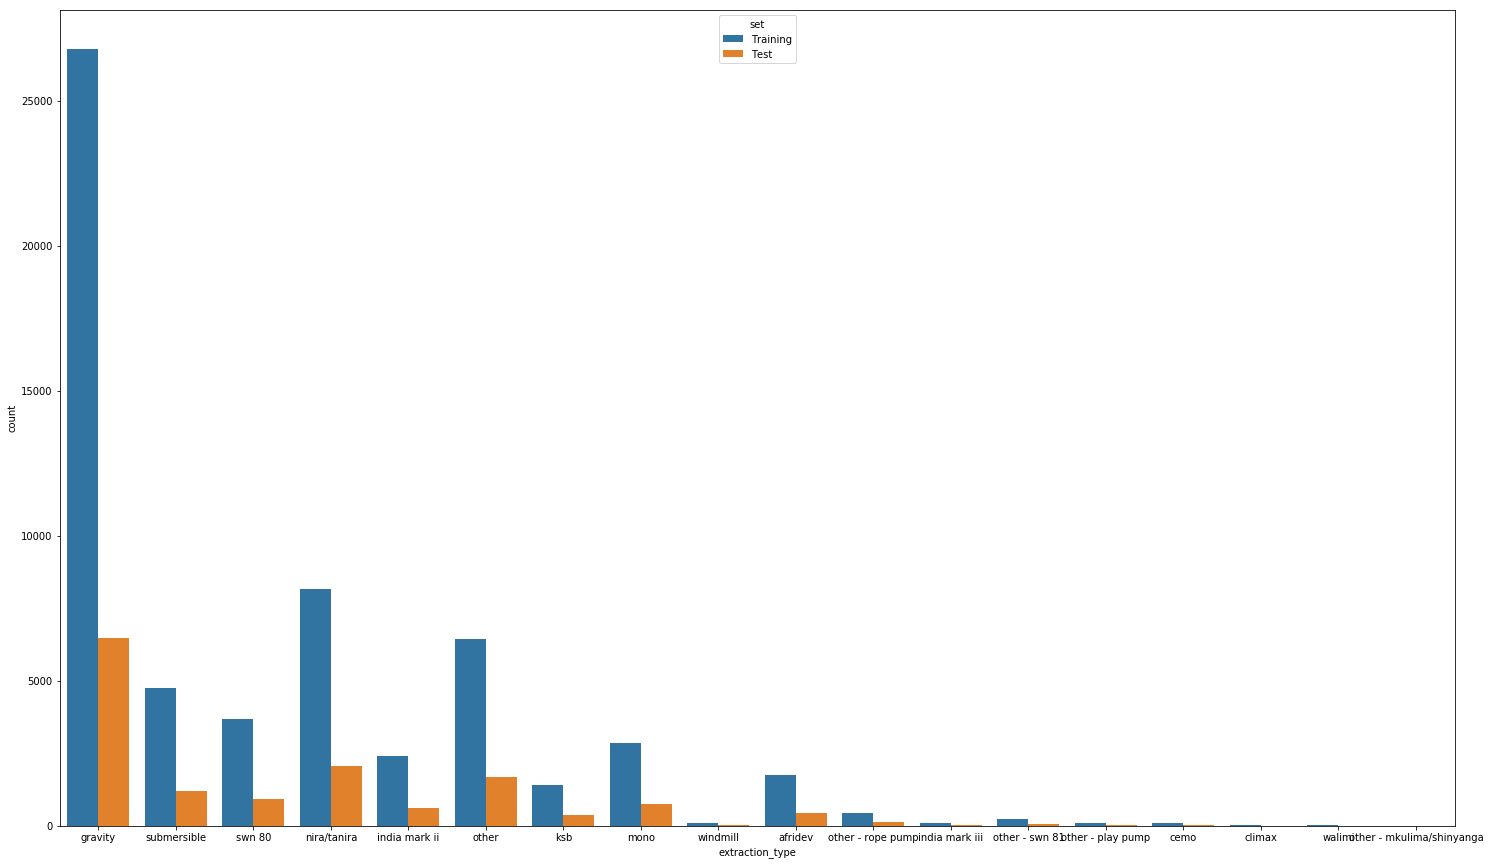

In [62]:
#Looks like extraction_type is too detailed and some categories are not presented in the Test Set
fig = plt.figure(figsize=(25,15))
sns.countplot(x='extraction_type', hue='set', data=df);

Based on the table below (the information from the rest two variables), we decided to create new variable containing rather granular level (presented both in Train and Test set)

In [63]:
pd.crosstab(df['extraction_type_group'], df['extraction_type_class'], margins=True)

extraction_type_class,gravity,handpump,motorpump,other,rope pump,submersible,wind-powered,All
extraction_type_group,,,,,,,,
afridev,0,2208,0,0,0,0,0,2208
gravity,33263,0,0,0,0,0,0,33263
india mark ii,0,3029,0,0,0,0,0,3029
india mark iii,0,135,0,0,0,0,0,135
mono,0,0,3628,0,0,0,0,3628
nira/tanira,0,10205,0,0,0,0,0,10205
other,0,0,0,8102,0,0,0,8102
other handpump,0,447,0,0,0,0,0,447
other motorpump,0,0,149,0,0,0,0,149


In [64]:
def extract (row):  
    if row['extraction_type_group']=='gravity':
        return 'Gravity'
    elif row['extraction_type_group']=='nira/tanira':
        return 'Nira/tanira'
    elif row['extraction_type_group']=='submersible':
        return 'Submersible'     
    elif row['extraction_type_group']=='swn 80':
        return 'Swn 80'       
    elif row['extraction_type_group']=='india mark iii':
        return 'India mark'
    elif row['extraction_type_group']=='india mark ii':
        return 'India mark'    
    elif row['extraction_type_group']=='afridev':
        return 'Afridev + other handpums'      
    elif row['extraction_type_group']=='other handpump':
        return 'Afridev + other handpums'      
    elif row['extraction_type_group']=='mono':
        return 'Mono + other motorpump'         
    elif row['extraction_type_group']=='other motorpump':
        return 'Mono + other motorpump'             
    elif row['extraction_type_group']=='rope pump':
        return 'rope pump + wind-powered'
    elif row['extraction_type_group']=='wind-powered':
        return 'rope pump + wind-powered'        
    elif row['extraction_type_group']=='other':
        return 'other'        
    
df['extraction_new'] = df.apply(lambda row: extract(row), axis=1)

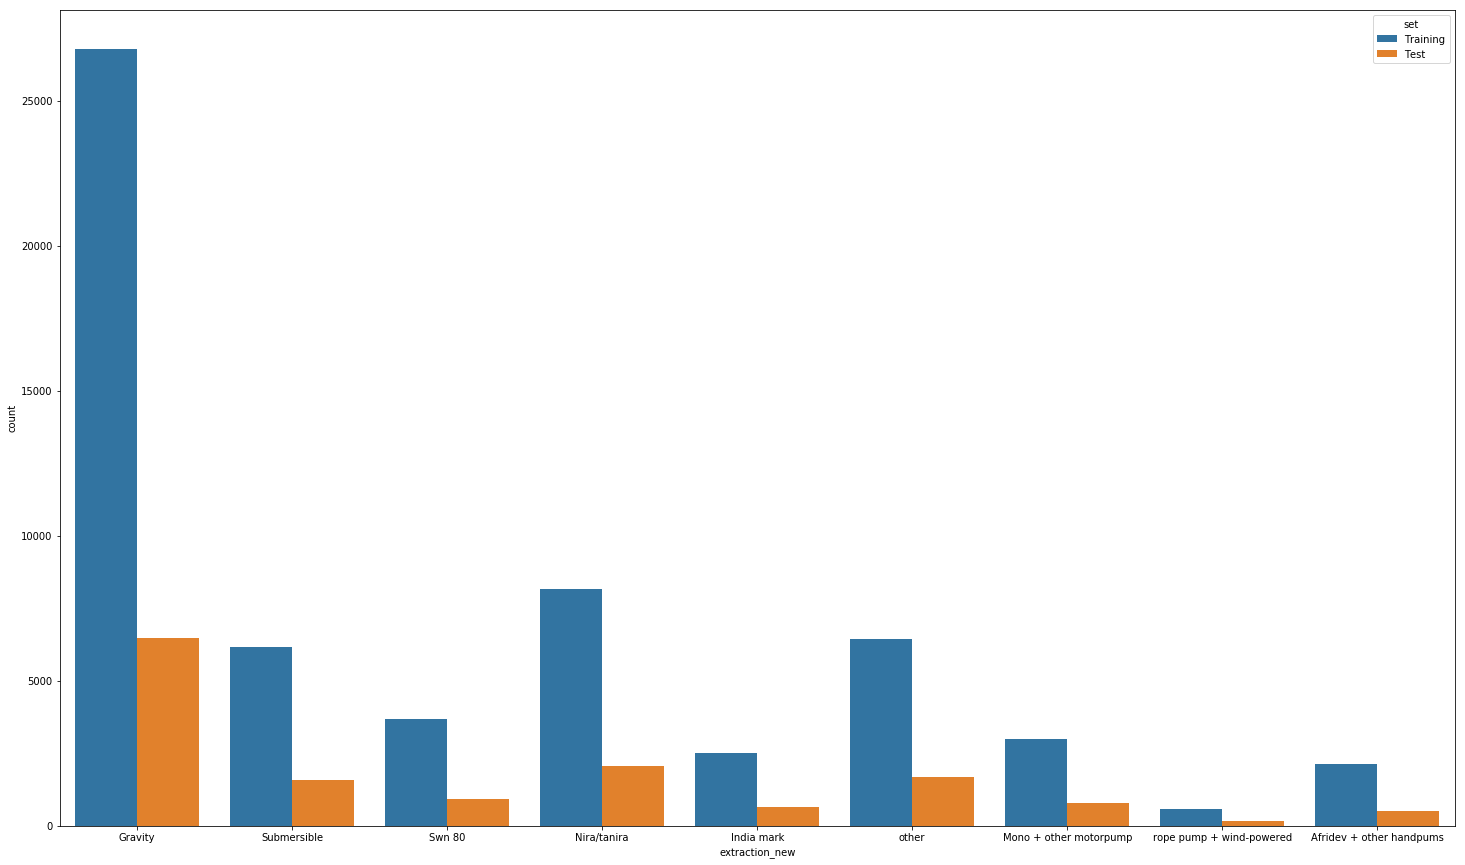

In [65]:
#Checking the distibution again
fig = plt.figure(figsize=(25,15))
sns.countplot(x='extraction_new', hue='set', data=df);

In [66]:
#We can drop the initial variables
df.drop(['extraction_type','extraction_type_group', 'extraction_type_class'], axis = 1, inplace = True) 

#### Management 

Now we are going to look at the management variables

scheme_management - Who operates the waterpoint
management - How the waterpoint is managed
management_group - How the waterpoint is managed


In [67]:
#We group management type variables
man_col = ['scheme_management', 'management', 'management_group']

In [68]:
df[man_col].describe(include=['object']).transpose()

,count,unique,top,freq
scheme_management,74250,13,VWC,45917
management,74250,12,vwc,50624
management_group,74250,5,user-group,65538


In [69]:
confusion_matrix = pd.crosstab(df['scheme_management'], df['management']).as_matrix()
cramers_v(confusion_matrix)

0.7494771543470509

In [70]:
confusion_matrix = pd.crosstab(df['scheme_management'], df['management_group']).as_matrix()
cramers_v(confusion_matrix)

0.6971823240442037

The test also records the high correlation between them. Also we can see that scheme management variable is more detailed one, but let's check the intersection more precisely.

In [71]:
pd.crosstab(df['scheme_management'], df['management'], margins=True)

management,company,other,other - school,parastatal,private operator,trust,unknown,vwc,water authority,water board,wua,wug,All
scheme_management,,,,,,,,,,,,,
Company,848,2,0,30,287,0,0,173,0,0,0,1,1341
No information,1,230,0,15,161,1,578,3065,2,0,8,785,4846
None,0,0,0,0,0,0,0,1,0,0,0,0,1
Other,0,690,0,1,78,1,9,49,21,0,0,147,996
Parastatal,0,0,0,1979,78,0,4,60,2,1,0,0,2124
Private operator,2,4,0,4,1208,1,0,100,5,1,0,1,1326
SWC,0,0,112,0,0,0,0,10,0,0,0,1,123
Trust,1,0,0,1,1,78,0,8,2,1,0,0,92
VWC,2,57,14,152,211,4,86,44185,9,52,138,1007,45917


The values encountered in scheme_management are nominally the same, but the intersection are different. Adn they quite confusing. So we decided to drop  scheme_management.

And now let's observe the other two.
We see that management_group is just more large categories of mangement 

In [72]:
# We will use a simple crosstab to compare the variables
pd.crosstab(df['management_group'], df['management'], margins=True)

management,company,other,other - school,parastatal,private operator,trust,unknown,vwc,water authority,water board,wua,wug,All
management_group,,,,,,,,,,,,,
commercial,859,0,0,0,2504,105,0,0,1123,0,0,0,4591
other,0,1083,126,0,0,0,0,0,0,0,0,0,1209
parastatal,0,0,0,2229,0,0,0,0,0,0,0,0,2229
unknown,0,0,0,0,0,0,683,0,0,0,0,0,683
user-group,0,0,0,0,0,0,0,50624,0,3688,3118,8108,65538
All,859,1083,126,2229,2504,105,683,50624,1123,3688,3118,8108,74250


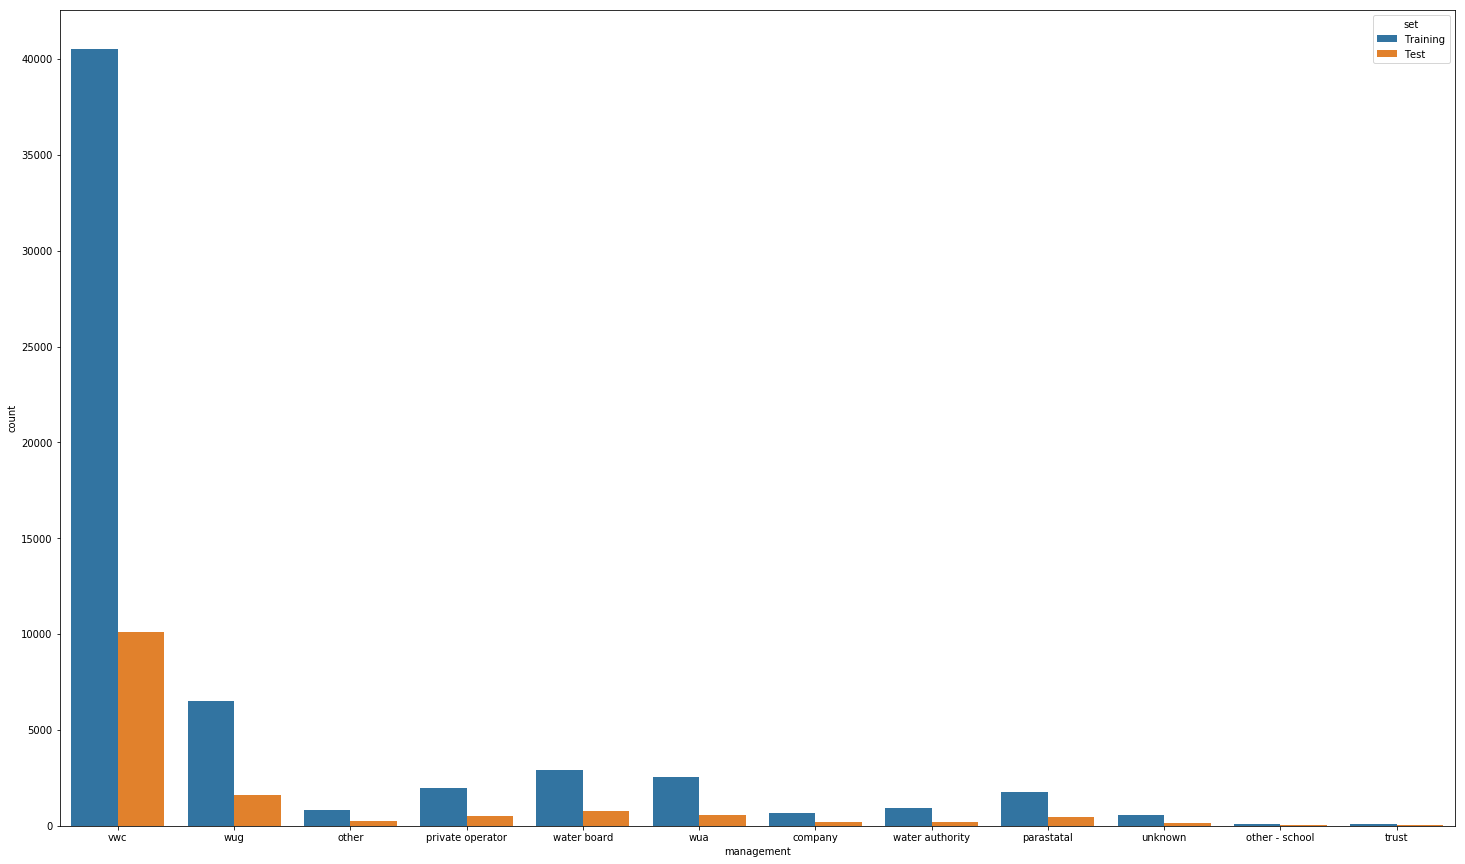

In [73]:
#It seems that we can re-group some categories and make it bigger
fig = plt.figure(figsize=(25,15))
sns.countplot(x='management', hue='set', data=df);

In [74]:
def man (row):  
    if row['management']=='vwc':
        return 'VWC'
    elif row['management']=='wug':
        return 'Wug'
    elif row['management']=='wua':
        return 'Wua'
    elif row['management']=='water board':
        return 'Water board'    
    elif row['management']=='private operator':
        return 'private operator'
    elif row['management']=='parastatal':
        return 'parastatal'
    elif row['management']=='water authority':
        return 'Other commercial'       
    elif row['management']=='company':
        return 'Other commercial'     
    elif row['management']=='trust':
        return 'Other commercial'        
    elif row['management']=='other - school':
        return 'Other'        
    elif row['management']=='other':
        return 'Other'                  
    elif row['management']=='unknown':
        return 'unknown'    
    
df['management_new'] = df.apply(lambda row: man (row), axis=1)

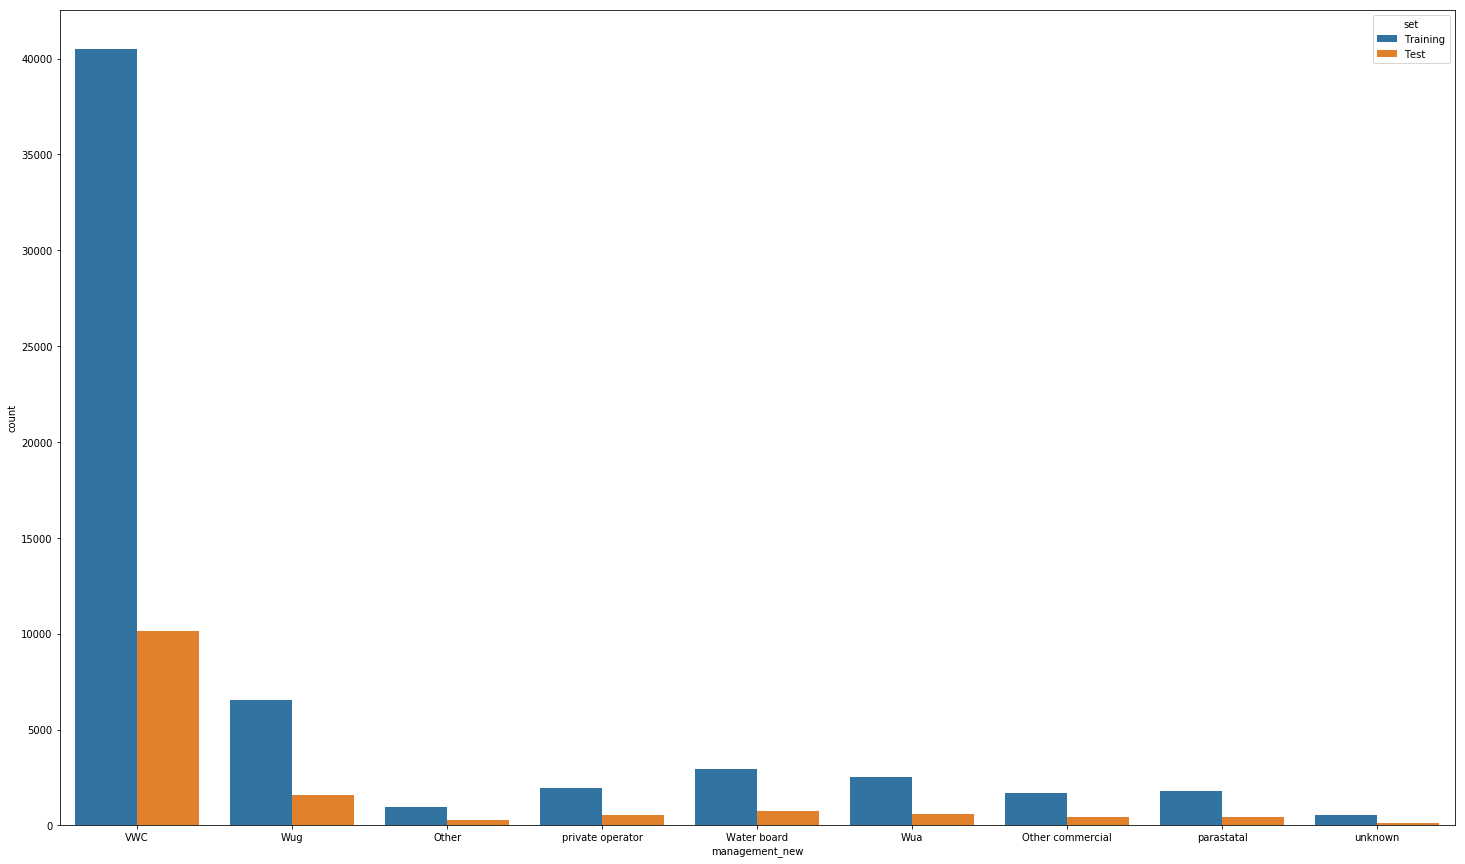

In [75]:
#Checking the distibution again
fig = plt.figure(figsize=(25,15))
sns.countplot(x='management_new', hue='set', data=df)

In [76]:
#We can drop the initial variables
df.drop(['scheme_management', 'management', 'management_group'], axis = 1, inplace = True) 

#### Payment

In [77]:
# We will use a simple crosstab to compare the variables
pd.crosstab(df['payment'], df['payment_type'], margins=True)

payment_type,annually,monthly,never pay,on failure,other,per bucket,unknown,All
payment,,,,,,,,
never pay,0,0,31712,0,0,0,0,31712
other,0,0,0,0,1314,0,0,1314
pay annually,4570,0,0,0,0,0,0,4570
pay monthly,0,10397,0,0,0,0,0,10397
pay per bucket,0,0,0,0,0,11266,0,11266
pay when scheme fails,0,0,0,4842,0,0,0,4842
unknown,0,0,0,0,0,0,10149,10149
All,4570,10397,31712,4842,1314,11266,10149,74250


In [78]:
# We can drop any variable since they are identic
df.drop(['payment_type'], axis = 1, inplace = True) 

#### Water quality

In [79]:
# We will use a simple crosstab to compare the variables
pd.crosstab(df['water_quality'], df['quality_group'], margins=True)

quality_group,colored,fluoride,good,milky,salty,unknown,All
water_quality,,,,,,,
coloured,623,0,0,0,0,0,623
fluoride,0,244,0,0,0,0,244
fluoride abandoned,0,23,0,0,0,0,23
milky,0,0,0,1005,0,0,1005
salty,0,0,0,0,6082,0,6082
salty abandoned,0,0,0,0,423,0,423
soft,0,0,63505,0,0,0,63505
unknown,0,0,0,0,0,2345,2345
All,623,267,63505,1005,6505,2345,74250


In [80]:
# We  will drop more detailed one (water_quality), since it provides not to much differentiation
df.drop(['water_quality'], axis = 1, inplace = True)

#### Quantity of water

In [81]:
# We will use a simple crosstab to compare the variables
pd.crosstab(df['quantity'], df['quantity_group'], margins=True)

quantity_group,dry,enough,insufficient,seasonal,unknown,All
quantity,,,,,,
dry,7782,0,0,0,0,7782
enough,0,41522,0,0,0,41522
insufficient,0,0,18896,0,0,18896
seasonal,0,0,0,5075,0,5075
unknown,0,0,0,0,975,975
All,7782,41522,18896,5075,975,74250


In [82]:
# We can drop any variable since they are identic
df.drop(['quantity_group'], axis = 1, inplace = True) 

#### Source of the water

In [83]:
#We group exctraction type
source_col = ['source', 'source_type', 'source_class']

In [84]:
df[source_col].describe(include=['object']).transpose()

,count,unique,top,freq
source,74250,10,spring,21216
source_type,74250,7,spring,21216
source_class,74250,3,groundwater,57286


In [85]:
confusion_matrix = pd.crosstab(df['source'], df['source_type']).as_matrix()
cramers_v(confusion_matrix)

0.9999797958709475

In [86]:
confusion_matrix = pd.crosstab(df['source'], df['source_class']).as_matrix()
cramers_v(confusion_matrix)

0.9999528589370774

In [87]:
#We will keep the most detailed variable
df.drop(['source_type', 'source_class'], axis = 1, inplace = True) 

#### Source of the water

In [88]:
# We will use a simple crosstab to compare the variables
pd.crosstab(df['waterpoint_type'], df['waterpoint_type_group'], margins=True)

waterpoint_type_group,cattle trough,communal standpipe,dam,hand pump,improved spring,other,All
waterpoint_type,,,,,,,
cattle trough,150,0,0,0,0,0,150
communal standpipe,0,35628,0,0,0,0,35628
communal standpipe multiple,0,7611,0,0,0,0,7611
dam,0,0,8,0,0,0,8
hand pump,0,0,0,21884,0,0,21884
improved spring,0,0,0,0,959,0,959
other,0,0,0,0,0,8010,8010
All,150,43239,8,21884,959,8010,74250


In [89]:
# We will choose more detailed one (waterpoint_type), since it provides slightly more differentiation (by introducing another big class -communal standpipe multiple)
df.drop(['waterpoint_type_group'], axis = 1, inplace = True)

In [90]:
#Checking columns again
df.columns

Index(['amount_tsh', 'date_recorded', 'funder', 'gps_height', 'installer',
       'longitude', 'latitude', 'basin', 'region', 'district_code', 'ward',
       'population', 'public_meeting', 'permit', 'construction_year',
       'payment', 'quality_group', 'quantity', 'source', 'waterpoint_type',
       'status_group', 'set', 'type_region', 'extraction_new',
       'management_new'],
      dtype='object')

In [91]:
#Saving results to use different strategies for numeric missing values imputation
df_cat=pd.DataFrame.copy (df)
df_num1=pd.DataFrame.copy(df_cat)
df_num2=pd.DataFrame.copy(df_cat)
df_num3=pd.DataFrame.copy(df_cat)

## 1.4 Handling the numeric variables

In [92]:
# Getting the missing values for numerical data
df.select_dtypes(include=["float64","int64"]).isna().sum().sort_values(ascending=False)

construction_year    0
population           0
latitude             0
longitude            0
gps_height           0
amount_tsh           0
dtype: int64

In [93]:
#Now we will get the numerical variables with a lot of levels
df.select_dtypes(include=["float64","int64"]).nunique().sort_values(ascending=False)

longitude            71870
latitude             71869
gps_height            2456
population            1128
amount_tsh             102
construction_year       55
dtype: int64

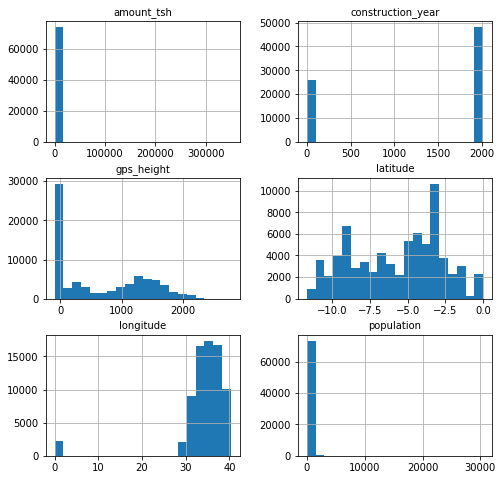

In [94]:
%matplotlib inline
import matplotlib.pylab as plt
attribute_columns = list(df.columns)
if True:
    fontsize = 10
    fig = df[attribute_columns].hist(bins = 20, figsize = (8, 8),
                                       xlabelsize=fontsize,
                                       ylabelsize=fontsize)
    for x in fig.ravel():
        x.title.set_size(fontsize)
else:
    nrows = (len(attribute_columns)+1) // 2
    plt.figure(figsize=(12,25))
    for i in range(len(attribute_columns)):
        name = attribute_columns[i]
        plt.subplot(nrows,2,i+1)
        data[name].hist()
        plt.title(name, fontsize=14)
    
plt.show()

We found that most part of numeric variables contains a lot of data values represented by zeroes

Let's first examine the GPS coordinates of longitude and latitude. Looks like there are many typical values there

https://www.mapsofworld.com/lat_long/tanzania-lat-long.html


We see that there is a strange extreme values of the GPS coordinates 

Lat-long coorditates for cities in Tanzania are in range: Latitude from -11.36667 to -1.14389 and longitude from 29.62667 to 40.33333 (source: https://latitudelongitude.org/tz/). 

So zeros are incorrect  values.

In [95]:
df['longitude'].value_counts().head(10)

0.000000     2269
37.250111       2
32.996093       2
37.541579       2
32.993683       2
39.094535       2
37.532778       2
39.103752       2
39.096123       2
37.542785       2
Name: longitude, dtype: int64

In [96]:
df['latitude'].value_counts().head()

-2.000000e-08    2269
-6.980122e+00       2
-6.980779e+00       2
-2.467137e+00       2
-6.964468e+00       2
Name: latitude, dtype: int64

In [97]:
#We see if 'longitude' equals to zero, so latitude is recorded incorrectly
df[df['longitude']==0]['latitude'].value_counts()

-2.000000e-08    2269
Name: latitude, dtype: int64

In [98]:
# Replacing zeros with missing values
df = df.replace({'longitude':0}, np.nan)

In [99]:
# Replacing 2.000000e-08 with missing values
df = df.replace({'latitude':-2.000000e-08}, np.nan)

Using the describe method we identified the strange extreme values for gps height  as well. 
We cans see that minimum height is -90m while nominally Tanzania lowest level is sea level. 
However, in reality there is almost a fraction of territories with elevation level equals to zero


Elevation map:

http://www.floodmap.net/Elevation/CountryElevationMap/?ct=TZ

In [100]:
#Checking the gps_height parameter 
df['gps_height'].describe()

count    74250.000000
mean       665.667313
std        692.761033
min        -90.000000
25%          0.000000
50%        364.000000
75%       1317.000000
max       2777.000000
Name: gps_height, dtype: float64

In [101]:
# 25659 cases are recorded incorrectly
df['gps_height'][df['gps_height']<=0].describe()

count    27530.000000
mean        -1.369706
std          5.970234
min        -90.000000
25%          0.000000
50%          0.000000
75%          0.000000
max          0.000000
Name: gps_height, dtype: float64

So basically there are two steps for height incorrect records in gps_height:
     1) We can treat negative values as typo with 'minus' and use the absolute function to correct the mistake
     2) We replace zeros with missing values and make imputations

In [102]:
#  We decided to count this rather as typo with 'minus'
df['gps_height'] = abs(df['gps_height'])

In [103]:
# Replacing zeros with missing values
df = df.replace({'gps_height':0}, np.nan)

We could replace each of these extreme values with their field means but we can be more accurate. Instead we select all coordinates that are in the correct coordinate box and compute their average per 'region' and 'district_code' . This way instead of replacing all incorrect values by a common substitute we replace them by local averages.

In [104]:
# Calculating the mean of Longitude  based on geolocation variables (from more granular to the less one)
df['longitude'].fillna(df.groupby(['region','district_code'])['longitude'].transform ('mean'), inplace=True)

# Since there was some missing value exist, fro step 2 we will use more light version of groupby table
df['longitude'].fillna(df.groupby(['region'])['longitude'].transform ('mean'), inplace=True)

# Finnally for rough imputation
df['longitude'].fillna(np.mean(df.longitude), inplace=True)

In [105]:
# Calculating the mean of Latitude based on geolocation variables (from more granular to the less one)
df['latitude'].fillna(df.groupby(['region', 'district_code'])['latitude'].transform ('mean'), inplace=True)

# Since there was some missing value exist, fro step 2 we will use more light version of groupby table
df['latitude'].fillna(df.groupby(['region'])['latitude'].transform ('mean'), inplace=True)

# Finnally for rough imputation
df['latitude'].fillna(np.mean(df.latitude), inplace=True)

In [106]:
# Calculating the mean of Longitude  based on geolocation variables (from more granular to the less one)
df['gps_height'].fillna(df.groupby(['region','district_code'])['gps_height'].transform ('mean'), inplace=True)

# Since there was some missing value exist, fro step 2 we will use more light version of groupby table
df['gps_height'].fillna(df.groupby(['region'])['gps_height'].transform ('mean'), inplace=True)

# Finnally for rough imputation
df['gps_height'].fillna(np.mean(df.gps_height), inplace=True)

Now we will inspect the population and contsruction_year variables

In [107]:
df['construction_year'].describe()

count    74250.000000
mean      1298.463650
std        952.349375
min          0.000000
25%          0.000000
50%       1986.000000
75%       2004.000000
max       2013.000000
Name: construction_year, dtype: float64

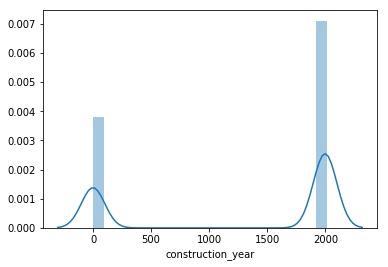

In [108]:
sns.distplot(df['construction_year'])

In [109]:
df.pivot_table(['construction_year'], ['status_group','set'], aggfunc='describe')

construction_year                           \
                                               25%     50%     75%    count   
status_group            set                                                   
                        Test                   0.0  1986.0  2004.0  14850.0   
functional              Training               0.0  1995.0  2007.0  32259.0   
functional needs repair Training               0.0  1978.0  2000.0   4317.0   
non functional          Training               0.0  1980.0  1999.0  22824.0   

                                                                        
                                     max         mean  min         std  
status_group            set                                             
                        Test      2013.0  1289.708350  0.0  955.241087  
functional              Training  2013.0  1345.567718  0.0  938.407231  
functional needs repair Training  2013.0  1168.406764  0.0  983.063724  
non functional          Training  2013.0  1262.183491  0.0  960.112104

In [110]:
df['population'].describe()

count    74250.000000
mean       180.750828
std        471.086120
min          0.000000
25%          0.000000
50%         25.000000
75%        215.000000
max      30500.000000
Name: population, dtype: float64

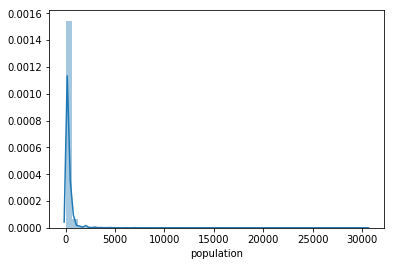

In [111]:
sns.distplot(df['population'])

In [112]:
df.pivot_table(['population'], ['status_group','set'], aggfunc='describe')

population                                 \
                                        25%   50%    75%    count      max   
status_group            set                                                  
                        Test            0.0  20.0  220.0  14850.0  11469.0   
functional              Training        0.0  40.0  200.0  32259.0  30500.0   
functional needs repair Training        0.0  25.0  245.0   4317.0  15300.0   
non functional          Training        0.0   1.0  230.0  22824.0   9865.0   

                                                               
                                        mean  min         std  
status_group            set                                    
                        Test      184.114209  0.0  469.499332  
functional              Training  187.553303  0.0  513.198991  
functional needs repair Training  175.102154  0.0  433.033756  
non functional          Training  170.016430  0.0  413.094978

Before going further we decided to replace zero values with NaNs

In [113]:
# Replacing zeros with 'NaN' 
df = df.replace({'construction_year':0}, np.nan)
df = df.replace({'population':0}, np.nan)

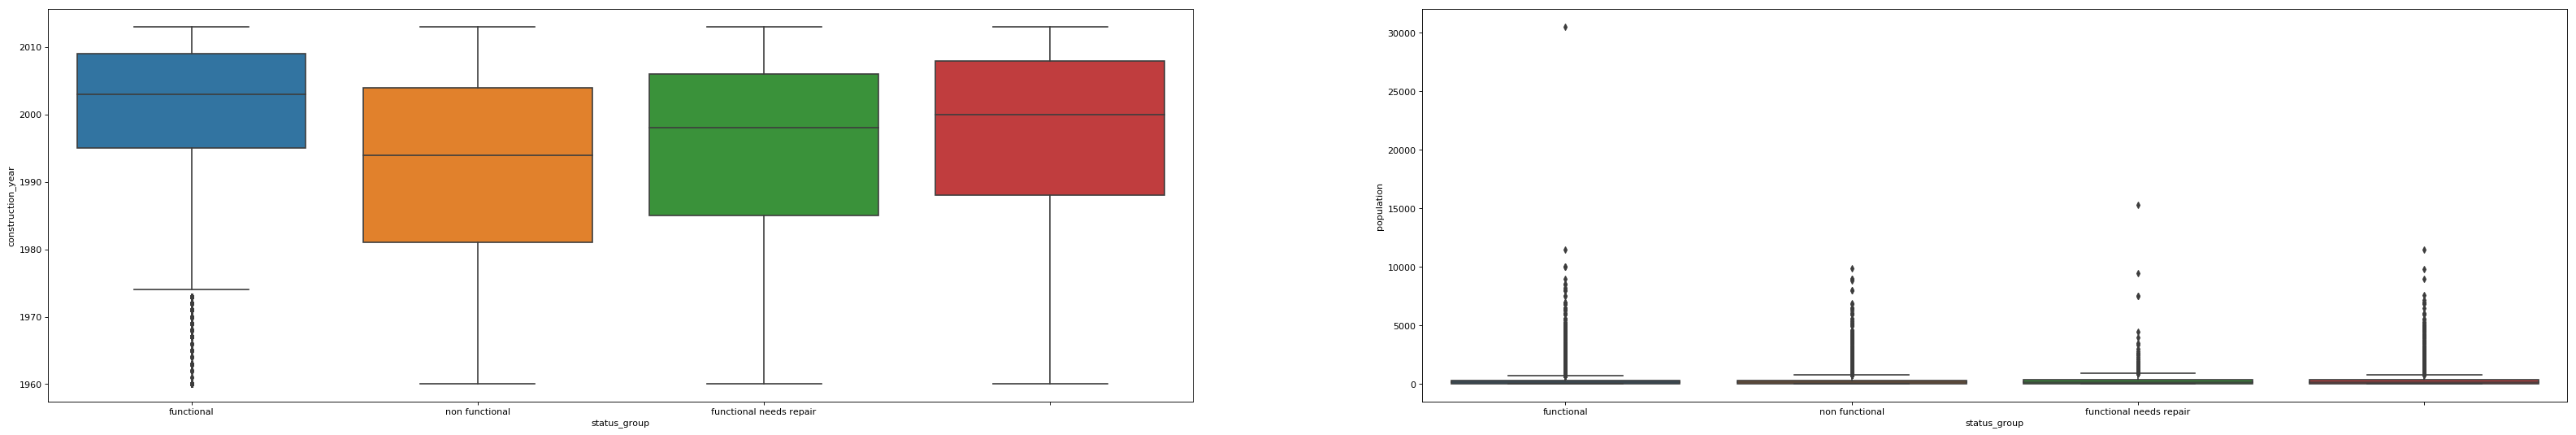

In [114]:
#Plotting the boxplots for Outliers checking
#Box plots use the IQR method to display data and outliers
fig, axes = plt.subplots(1, 2, figsize=(50,8), dpi= 80)
sns.boxplot(x='status_group', y='construction_year', data=df, ax=axes[0])
sns.boxplot(x='status_group', y='population', data=df, ax=axes[1])
plt.show()

From the boxplots we can see that the older the water pumps the more they are broken or in need of repairs.

In [115]:
df['construction_year'].describe()

count    48281.000000
mean      1996.870943
std         12.440524
min       1960.000000
25%       1988.000000
50%       2000.000000
75%       2008.000000
max       2013.000000
Name: construction_year, dtype: float64

In [116]:
df['population'].describe()

count    47416.000000
mean       283.042623
std        564.413842
min          1.000000
25%         40.000000
50%        150.000000
75%        328.000000
max      30500.000000
Name: population, dtype: float64

We would replace each of these the zero values using the same strategy as for GEO coordinates
But instead of mean we will use median (since its better for the representation of imputed variables nature)

In [117]:
# Calculating the mean of Construction year based on geolocation variables (from more granular to the less one)
df['construction_year'].fillna(df.groupby(['region', 'district_code'])['construction_year'].transform ('median'), inplace=True)

# Since there was some missing value exist, fro step 2 we will use more light version of groupby table
df['construction_year'].fillna(df.groupby(['region'])['construction_year'].transform ('median'), inplace=True)

# Finnally for rough imputation
df['construction_year'].fillna(df['construction_year'].median(), inplace=True)

In [118]:
# Calculating the mean of Population n based on geolocation variables (from more granular to the less one)
df['population'].fillna(df.groupby(['region', 'district_code'])['population'].transform ('median'), inplace=True)

# Since there was some missing value exist, fro step 2 we will use more light version of groupby table
df['population'].fillna(df.groupby(['region'])['population'].transform ('median'), inplace=True)

# Finnally for rough imputation
df['population'].fillna(df['population'].median(), inplace=True)

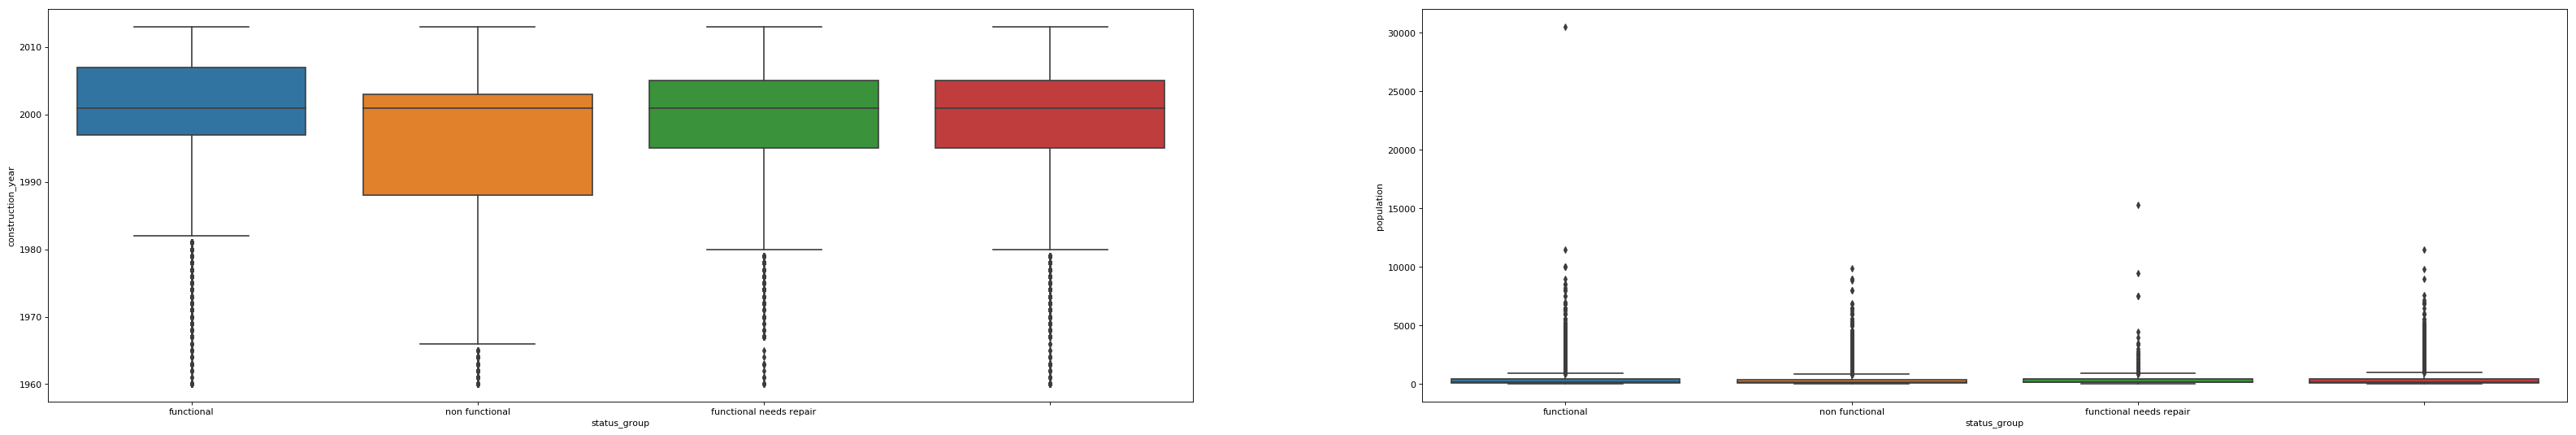

In [119]:
fig, axes = plt.subplots(1, 2, figsize=(50,8), dpi= 80)
sns.boxplot(x='status_group', y='construction_year', data=df, ax=axes[0])
sns.boxplot(x='status_group', y='population', data=df, ax=axes[1])
plt.show()

In [120]:
df['construction_year'].skew()

-1.187190596055673

In [121]:
df['population'].skew()

11.884377744459057

We can see that there are outliers in this variables and both of them are skewed (especially population). 
We will use the IQR to detect and replace them with the median

In [122]:
#In order to get physically the list of identified outlier, we will need to use the mathematical formula and retrieve the outlier data.
from scipy import stats
Q1_cy = df['construction_year'].quantile(0.25)
Q3_cy = df['construction_year'].quantile(0.75)
IQR_cy = Q3_cy - Q1_cy
#Here we will get IQR 
print(IQR_cy)

10.0


In [123]:
median_cy = df['construction_year'].median()
outliers_cy = ((df['construction_year'] < (Q1_cy - 1.5 * IQR_cy)) | (df['construction_year'] > (Q3_cy + 1.5 * IQR_cy)))
df['construction_year'][outliers_cy] = np.nan
df['construction_year'].fillna(median_cy, inplace=True)

In [124]:
Q1_pop = df['population'].quantile(0.25)
Q3_pop = df['population'].quantile(0.75)
IQR_pop = Q3_pop - Q1_pop
#Here we will get IQR 
print(IQR_pop)

340.0


In [125]:
median_pop = df['population'].median()
outliers_pop = ((df['population'] < (Q1_pop - 1.5 * IQR_pop)) | (df['population'] > (Q3_pop + 1.5 * IQR_pop)))
df['population'][outliers_pop] = np.nan
df['population'].fillna(median_pop, inplace=True)

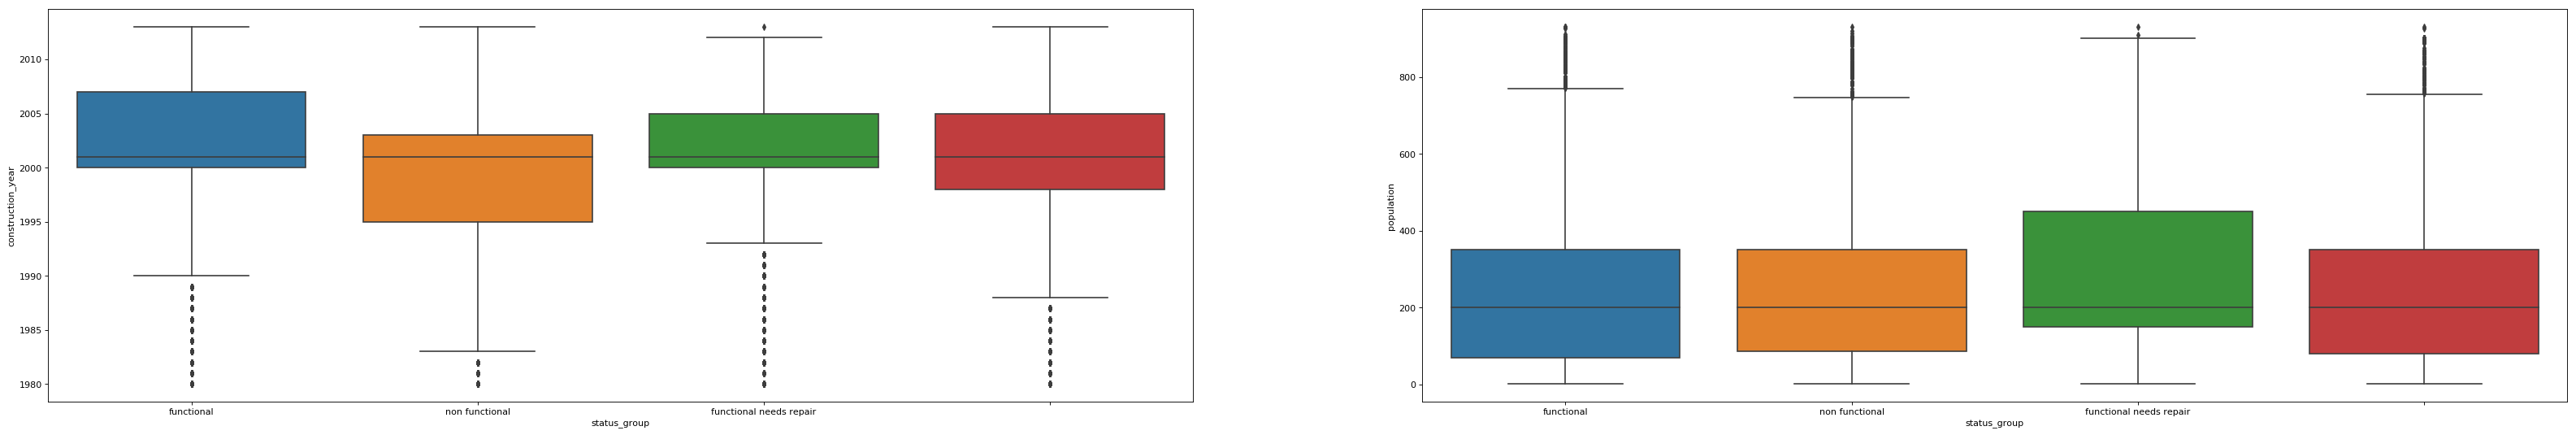

In [126]:
fig, axes = plt.subplots(1, 2, figsize=(50,8), dpi= 80)
sns.boxplot(x='status_group', y='construction_year', data=df, ax=axes[0])
sns.boxplot(x='status_group', y='population', data=df, ax=axes[1])
plt.show()

The description of amount_tsh identifies amount_tsh as the amount available to the water point. In technical terms that means the 'total static head' in meters. Total static head indicates the height at which the pump can rais up water, so the value 0 is not possible because that value represent 'the elevation between the surface of the reservoir and the point of discharge into receiving tank'. Other interpretation can be that 0 means that the value is missing.

https://www.pumpfundamentals.com/

So basically, there are two options:
a) the value 0 is correct because they consider that total static head is 0 because the pump is not working
b) the could not measure/check the value of the total static head, in that case is a missing value

In [127]:
#Since there is around 70% of missing values, we will drop this columns too
df['amount_tsh'].value_counts().head(5)

0.0       52049
500.0      3874
50.0       3103
1000.0     1858
20.0       1812
Name: amount_tsh, dtype: int64

In [128]:
#We see that zero values are recoded for 50% of functional pumps, so we decided to discard this variable
df.iloc[0:59400,].groupby(['status_group'])['amount_tsh'].describe()

,count,mean,std,min,25%,50%,75%,max
status_group,,,,,,,,
functional,32259.0,461.798235,3889.735284,0.0,0.0,0.0,50.0,350000.0
functional needs repair,4317.0,267.071577,1925.026420,0.0,0.0,0.0,50.0,100000.0
non functional,22824.0,123.481230,1110.120571,0.0,0.0,0.0,0.0,117000.0


In [129]:
df.drop(['amount_tsh'], axis = 1, inplace = True) 

# 2. Feature Engineering

## 2.1 Exctracting valuable information from Dates

In [130]:
import datetime
#We will exctract year/quater/month/day/dayofweek
df['year'] = df['date_recorded'].dt.year
df['quarter'] = df['date_recorded'].dt.quarter
df['month'] = df['date_recorded'].dt.month
df['dayofweek_name'] = df['date_recorded'].dt.weekday_name
df['is_weekend'] = np.where(df['dayofweek_name'].isin(['Sunday','Saturday']),1,0)
df['day'] = df['date_recorded'].dt.day

In [131]:
#Setting quater/month/dayofweek as categorical variables
df['month'] = df.month.astype('object')
df['quarter'] = df.quarter.astype('object')
df['dayofweek_name'] = df.dayofweek_name.astype('object')

In [132]:
df['date_recorded'].max()

Timestamp('2013-12-03 00:00:00')

In [133]:
#Calculating the number of days since the last date and deleting the intitial variable
df.date_recorded = pd.datetime(2013, 12, 3) - pd.to_datetime(df.date_recorded)
df.columns = ['days_since_recorded' if x=='date_recorded' else x for x in df.columns]
df.days_since_recorded = df.days_since_recorded.astype('timedelta64[D]').astype('int64')
df.days_since_recorded.describe()

count    74250.000000
mean       614.589010
std        335.101799
min          0.000000
25%        297.000000
50%        419.000000
75%        977.000000
max       4635.000000
Name: days_since_recorded, dtype: float64

In [134]:
#Calculating the difference between construction year and year of record
df['diff_years'] = df['year'] - df['construction_year']

## 2.2 Creating variable Season

We also noticed that the date the water pump was entered in the system should not influence the functional state of the water pump. But maybe the time of year could play an influential role. Tanzania has two rainy seasons and two dry seasons. 
The main rainy season or the ‘long rains’ happens during March, April and May. This is followed by the long dry season in June, July, August, September and October. In November and December, there’s a smaller rainy season or the ‘short rains’. January and February are called the ‘short dry season’ (ExpertAfrica, sd). This is summarized in table . 
If the water pump was recorded during the ‘Long rains’ season 60% was functional, whereas recordings in the ‘Short Dry’ season only has a functional percentage of 50%. The seasons are a relevant factor that has influence on our focal variable, that’s why these seasons captured in the newly created RecordingSeason variable.


https://drive.google.com/open?id=1Dt16RHHuTH_ENJd8WUqbP4XRmsr-tUaF

https://drive.google.com/open?id=10yN55fQHdC_n9hRghZm7mcTB52VEtJh3

In [135]:
#Creating function for the Seasons variable
def season_cat (row):
    if  1<=row <=2:
        return 'Short Dry Season'   
    elif 3<=row <=5:
         return 'Long rains'           
    elif 6<=row <=10:
         return 'Long dry seasons'        
    else:
         return 'Short Rains'

In [136]:
# Applying the function
df['season']=df['month'].apply(season_cat)

In [137]:
#Before dummification we are dropping the variable Set
df.drop(['set'], axis = 1, inplace = True) 

In [138]:
#Checking the columns
df.columns

Index(['days_since_recorded', 'funder', 'gps_height', 'installer', 'longitude',
       'latitude', 'basin', 'region', 'district_code', 'ward', 'population',
       'public_meeting', 'permit', 'construction_year', 'payment',
       'quality_group', 'quantity', 'source', 'waterpoint_type',
       'status_group', 'type_region', 'extraction_new', 'management_new',
       'year', 'quarter', 'month', 'dayofweek_name', 'is_weekend', 'day',
       'diff_years', 'season'],
      dtype='object')

In [139]:
#Checking the datatypes
df.dtypes

days_since_recorded      int64
funder                  object
gps_height             float64
installer               object
longitude              float64
latitude               float64
basin                   object
region                  object
district_code           object
ward                    object
population             float64
public_meeting          object
permit                  object
construction_year      float64
payment                 object
quality_group           object
quantity                object
source                  object
waterpoint_type         object
status_group            object
type_region             object
extraction_new          object
management_new          object
year                     int64
quarter                 object
month                   object
dayofweek_name          object
is_weekend               int32
day                      int64
diff_years             float64
season                  object
dtype: object

In [140]:
#Checking the missing values
100*df.isnull().sum()/df.isnull().count()

days_since_recorded    0.0
funder                 0.0
gps_height             0.0
installer              0.0
longitude              0.0
latitude               0.0
basin                  0.0
region                 0.0
district_code          0.0
ward                   0.0
population             0.0
public_meeting         0.0
permit                 0.0
construction_year      0.0
payment                0.0
quality_group          0.0
quantity               0.0
source                 0.0
waterpoint_type        0.0
status_group           0.0
type_region            0.0
extraction_new         0.0
management_new         0.0
year                   0.0
quarter                0.0
month                  0.0
dayofweek_name         0.0
is_weekend             0.0
day                    0.0
diff_years             0.0
season                 0.0
dtype: float64

# 3. Categorical data transformation before modelling

In [141]:
#Grab the target var from database
y = df.pop('status_group')

In [142]:
#We will use a function for get only categorical variables
def get_specific_columns(df, data_types):
    columns = df.select_dtypes(include=data_types).columns
    return columns
var_cat = get_specific_columns(df, ["object"])
var_cat

Index(['funder', 'installer', 'basin', 'region', 'district_code', 'ward',
       'public_meeting', 'permit', 'payment', 'quality_group', 'quantity',
       'source', 'waterpoint_type', 'type_region', 'extraction_new',
       'management_new', 'quarter', 'month', 'dayofweek_name', 'season'],
      dtype='object')

In [143]:
#We will use a function for dummies creation
def generate_dummies(df, dummy_columns):
    """Function to create dummified features out of categorical features"""
    dummies = pd.get_dummies(df[dummy_columns], drop_first=False)
    df = pd.concat([df, dummies], axis=1)
    return df

In [144]:
#Recoding to dummies and dropping the transformed columns
df_dummified= generate_dummies(df, var_cat)
X=df_dummified.drop(columns=var_cat, axis=1)

In [145]:
X.shape

(74250, 214)

# 4. Modelling

In [146]:
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score

In [147]:
X_dummy = X.iloc[0:59400,]
y_dummy = y.iloc[0:59400,]

In [148]:
X_train, X_test, y_train, y_test = train_test_split(X_dummy, y_dummy, test_size=0.3, random_state=444)

## 4.1. Logistic Regression as a Baseline Model 

In [149]:
y_dummy.value_counts()

functional                 32259
non functional             22824
functional needs repair     4317
Name: status_group, dtype: int64

In [150]:
from sklearn.linear_model import LogisticRegression
logmodel_bl = LogisticRegression(random_state=444)
logmodel_bl.fit(X_train,y_train)
log_predictions_bl = logmodel_bl.predict(X_test)
print(accuracy_score(y_test,log_predictions_bl))

0.7465207631874299


In [151]:
#We using cross-validation with 3 folds in order to get more reliable accuracy scores
from sklearn.model_selection import cross_val_score
accuracy_bl = cross_val_score(logmodel_bl,
                            X_dummy,
                            y_dummy,
                            cv=3,
                            scoring='accuracy')
print('Accuracy scores: ', accuracy_bl)
print("Mean accuracy::{}".format(accuracy_bl.mean()))
baseline_score = np.mean(accuracy_bl)

Accuracy scores:  [0.74590909 0.74111111 0.74631313]
Mean accuracy::0.7444444444444445


## 4.2. Logistic Regression with imputation of incorrect numeric values by Iterative Imputer

Here we will try another (AI strategy) for numeric incorrect values imputation.
We will alllow algorithm to choose the most appropriate values for substitution.
For that purpose we preliminary saved all the categorical tranformations in another dataframe df_num1.


In the example below BayesianRidge (regularized linear regression) and ExtraTreesRegressor provide the best results for imputation.


https://scikit-learn.org/dev/auto_examples/impute/plot_iterative_imputer_variants_comparison.html#sphx-glr-auto-examples-impute-plot-iterative-imputer-variants-comparison-py

We will try to use ExtraTreesRegressor

In [152]:
df_num1.columns

Index(['amount_tsh', 'date_recorded', 'funder', 'gps_height', 'installer',
       'longitude', 'latitude', 'basin', 'region', 'district_code', 'ward',
       'population', 'public_meeting', 'permit', 'construction_year',
       'payment', 'quality_group', 'quantity', 'source', 'waterpoint_type',
       'status_group', 'set', 'type_region', 'extraction_new',
       'management_new'],
      dtype='object')

In [153]:
df_num1.drop(['amount_tsh'], axis = 1, inplace = True) 

In [154]:
#We will use a function for get only categorical variables
def get_specific_columns(df_num1, data_types):
    columns = df_num1.select_dtypes(include=data_types).columns
    return columns
num_cat1 = get_specific_columns(df_num1, ["float64", "int64"])
num_cat1

Index(['gps_height', 'longitude', 'latitude', 'population',
       'construction_year'],
      dtype='object')

As we remember, the main problem among numeric variables are with the following parameters:

longitude - GPS coordinate
latitude - GPS coordinate
gps_height - Altitude of the well
population - Population around the well
construction_year - year the waterpoint was constructed

In [155]:
# Replacing incorrect values with 'NaN' 
df_num1 = df_num1.replace({'longitude':0}, np.nan)
df_num1 = df_num1.replace({'latitude':-2.000000e-08}, np.nan)
df_num1 = df_num1.replace({'construction_year':0}, np.nan)
df_num1 = df_num1.replace({'population':0}, np.nan)

# Replacing gps_height below zero with positive values
df_num1 ['gps_height'] = abs(df_num1 ['gps_height'])
df_num1 = df_num1.replace({'gps_height':0}, np.nan)

In [156]:
100*df_num1.isnull().sum()/df_num1.isnull().count()

date_recorded         0.000000
funder                0.000000
gps_height           34.544108
installer             0.000000
longitude             3.055892
latitude              3.055892
basin                 0.000000
region                0.000000
district_code         0.000000
ward                  0.000000
population           36.140067
public_meeting        0.000000
permit                0.000000
construction_year    34.975084
payment               0.000000
quality_group         0.000000
quantity              0.000000
source                0.000000
waterpoint_type       0.000000
status_group          0.000000
set                   0.000000
type_region           0.000000
extraction_new        0.000000
management_new        0.000000
dtype: float64

In [157]:
#We will use Iterative Imputer to fill the numeric missing values

from sklearn.ensemble import ExtraTreesRegressor

from sklearn.experimental import enable_iterative_imputer  
from sklearn.impute import IterativeImputer

# Run imputer 
imp = IterativeImputer(ExtraTreesRegressor(random_state=444))
df_num1[num_cat1] = pd.DataFrame(imp.fit_transform(df_num1[num_cat1]), columns=df_num1[num_cat1].columns)

In [158]:
100*df_num1.isnull().sum()/df_num1.isnull().count()

date_recorded        0.0
funder               0.0
gps_height           0.0
installer            0.0
longitude            0.0
latitude             0.0
basin                0.0
region               0.0
district_code        0.0
ward                 0.0
population           0.0
public_meeting       0.0
permit               0.0
construction_year    0.0
payment              0.0
quality_group        0.0
quantity             0.0
source               0.0
waterpoint_type      0.0
status_group         0.0
set                  0.0
type_region          0.0
extraction_new       0.0
management_new       0.0
dtype: float64

In [159]:
#We have to re-run the whole code from FE part (it is just copy-pasted from relevant section)

import datetime
#We will exctract year/quater/month/day/dayofweek
df_num1['year'] = df_num1['date_recorded'].dt.year
df_num1['quarter'] = df_num1['date_recorded'].dt.quarter
df_num1['month'] = df_num1['date_recorded'].dt.month
df_num1['dayofweek_name'] = df_num1['date_recorded'].dt.weekday_name
df_num1['is_weekend'] = np.where(df_num1['dayofweek_name'].isin(['Sunday','Saturday']),1,0)
df_num1['day'] = df_num1['date_recorded'].dt.day



#Setting quater/month/dayofweek as categorical variables
df_num1['month'] = df_num1.month.astype('object')
df_num1['quarter'] = df_num1.quarter.astype('object')
df_num1['dayofweek_name'] = df_num1.dayofweek_name.astype('object')


#Calculating the number of days since the last date and deleting the intitial variable
df_num1.date_recorded = pd.datetime(2013, 12, 3) - pd.to_datetime(df_num1.date_recorded)
df_num1.columns = ['days_since_recorded' if x=='date_recorded' else x for x in df_num1.columns]
df_num1.days_since_recorded = df_num1.days_since_recorded.astype('timedelta64[D]').astype('int64')
df_num1.days_since_recorded.describe()


#Calculating the difference between construction year and year of record
df_num1['diff_years'] = df_num1['year'] - df_num1['construction_year']



#Creating function for the Seasons variable
def season_cat (row):
    if  1<=row <=2:
        return 'Short Dry Season'   
    elif 3<=row <=5:
         return 'Long rains'           
    elif 6<=row <=10:
         return 'Long dry seasons'        
    else:
         return 'Short Rains'
        
# Applying the function
df_num1['season']=df_num1['month'].apply(season_cat)        


#Before dummification we are dropping the variable Set
df_num1.drop(['set'], axis = 1, inplace = True) 

In [160]:
y_impt1 = df_num1.pop('status_group')
y_dummy_impt1=y_impt1.iloc[0:59400,]

In [161]:
#We will use a function for get only categorical variables
def get_specific_columns(df_num1, data_types):
    columns = df_num1.select_dtypes(include=data_types).columns
    return columns
var_cat1 = get_specific_columns(df_num1, ["object"])
var_cat1

Index(['funder', 'installer', 'basin', 'region', 'district_code', 'ward',
       'public_meeting', 'permit', 'payment', 'quality_group', 'quantity',
       'source', 'waterpoint_type', 'type_region', 'extraction_new',
       'management_new', 'quarter', 'month', 'dayofweek_name', 'season'],
      dtype='object')

In [162]:
#We will use a function for dummies creation
def generate_dummies(df_num1, dummy_columns):
    """Function to create dummified features out of categorical features"""
    dummies = pd.get_dummies(df_num1[dummy_columns], drop_first=False)
    df_num1 = pd.concat([df_num1, dummies], axis=1)
    return df_num1

In [163]:
#Recoding to dummies and dropping the transformed columns
df_num1_dummified= generate_dummies(df_num1, var_cat1)
X_impt1=df_num1_dummified.drop(columns=var_cat1, axis=1)

In [164]:
X_dummy_impt1=X_impt1.iloc[0:59400,]

In [165]:
X_dummy_impt1.shape

(59400, 214)

In [166]:
X_train_impt1, X_test_impt1, y_train_impt1, y_test_impt1 = train_test_split(X_dummy_impt1, y_dummy_impt1, test_size=0.3, random_state=444)

In [167]:
from sklearn.linear_model import LogisticRegression
logmodel_impt1 = LogisticRegression(random_state=444)
logmodel_impt1.fit(X_train_impt1,y_train_impt1)
log_predictions_impt1 = logmodel_impt1.predict(X_test_impt1)
print(accuracy_score(y_test_impt1,log_predictions_impt1))

0.7470258136924803


In [168]:
#We using cross-validation with 3 folds in order to get more reliable accuracy scores
from sklearn.model_selection import cross_val_score
accuracy_impt1 = cross_val_score(logmodel_impt1,
                            X_dummy_impt1,
                            y_dummy_impt1,
                            cv=3,
                            scoring='accuracy')
print('Accuracy scores: ', accuracy_impt1)
print("Mean accuracy::{}".format(accuracy_impt1.mean()))
impt1_score = np.mean(accuracy_impt1)

Accuracy scores:  [0.74489899 0.7410101  0.74616162]
Mean accuracy::0.744023569023569


In [169]:
#There is NO improvement in the accuracy:
improvement = np.round(100*(impt1_score - baseline_score)/baseline_score,2)
print('Overall improvement is {} %'.format(improvement))

Overall improvement is -0.06 %


# 4.3. Features selection (as part of modelling process)

We will use our initial dummified database, since the second iteration idn't lead to any visible positive shift in comparison to our baseline model.

In this part we will experiment with the 3 different approaches:
- Variance threshold
- Univariate feature selection
- L1/L2 regularization

In [170]:
X_fs=X_dummy;
y_fs=y_dummy

###  4.3.1. Removing features with low variance

VarianceThreshold is a simple baseline approach to feature selection. It removes all features whose variance doesn’t meet some threshold. It doesn't take into consideration the relationship between predictors and target variable

In [172]:
#We will filter all the features with 10% variance. 
from sklearn.feature_selection import VarianceThreshold
sel = VarianceThreshold(threshold=0.1)
sel_var=sel.fit_transform(X_fs)
X_vt=X_fs[X_fs.columns[sel.get_support(indices=True)]];

In [173]:
#Cross-validation with 3 folds
logmodel_vt = LogisticRegression(random_state=444)
accuracy_vt = cross_val_score(logmodel_vt,
                            X_vt,
                            y_fs,
                            cv=3,
                            scoring='accuracy')
print('Accuracy scores: ', accuracy_vt)
print("Mean accuracy::{}".format(accuracy_vt.mean()))
vt_score= np.mean(accuracy_vt)

Accuracy scores:  [0.70015152 0.69358586 0.69575758]
Mean accuracy::0.6964983164983165


In [174]:
#There is a significant drop in accuracy
improvement = np.round(100*(vt_score - baseline_score)/baseline_score,2)
print('Overall improvement is {} %'.format(improvement))

Overall improvement is -6.44 %


In [175]:
# Search for an optimal value of threshold 

# Range of thresholds we want to try
thr = [0.1,0.2,0.3,0.4,0.5,0.6,0.7,0.8,0.9]

# Empty list to store accuracy scores
vt_scores = []

    # 1. we will loop through reasonable values of i
for i in thr:
    # 2. run VT with i variance threshold
    sel = VarianceThreshold(threshold=i)
    sel_var=sel.fit_transform(X_fs)
    X_vt=X_fs[X_fs.columns[sel.get_support(indices=True)]];
    
    #3. obtain cross_val_score for LogModel with certian threshold
    logmodel_vt = LogisticRegression(random_state=444)
    scores_vt = cross_val_score(logmodel_vt, X_vt, y_fs, cv=3, scoring='accuracy')
    #4. append mean of scores  into the scores list
    vt_scores.append(scores_vt.mean())


print(vt_scores)

[0.6964983164983165, 0.6638552188552188, 0.5704882154882155, 0.5704882154882155, 0.5704882154882155, 0.5704882154882155, 0.5704882154882155, 0.5704882154882155, 0.5704882154882155]


In [176]:
print('Length of list', len(vt_scores))
print('Max of list', max(vt_scores))

Length of list 9
Max of list 0.6964983164983165


In [178]:
best_vt_score=max(vt_scores)
improvement = np.round(100*(best_vt_score- baseline_score)/baseline_score,2)
print('Overall improvement is {} %'.format(improvement))

Overall improvement is -6.44 %


We obviously see that there is only decrease in the model perfomance. 
So we will not use this approach

### 4.3.2. Univariate feature selection

Univariate feature selection works by selecting the best features based on univariate statistical tests. We compare each feature to the target variable, to see whether there is any statistically significant relationship between them. When we analyze the relationship between one feature and the target variable, we ignore the other features. That is why it is called ‘univariate’. Each feature has its test score. Finally, all the test scores are compared, and the features with top scores will be selected. We will try to run ANOVA test (ANOVA F-value between label/feature for classification tasks).

https://scikit-learn.org/stable/modules/generated/sklearn.feature_selection.SelectPercentile.html#sklearn.feature_selection.SelectPercentile

In [179]:
from sklearn.feature_selection import SelectPercentile, f_classif

In [180]:
#We will start with choosing the 10% most significant features
feature_cols = X_fs.columns
selector = SelectPercentile(f_classif, percentile=10)
X_ufs_tr = selector.fit_transform(X_fs[feature_cols], y_fs)

# Get back the features we've kept, zero out all other features
selected_features = pd.DataFrame(selector.inverse_transform(X_ufs_tr), 
                                 index=X_fs.index, 
                                 columns=feature_cols)

# Dropped columns have values of all 0s, so var is 0, drop them
selected_columns = selected_features.columns[selected_features.var() != 0]
X_ufs=X_fs[selected_columns];
#Shape of reduced database
X_ufs.shape

(59400, 22)

In [181]:
#Model after leaving the 10 % of best features in relation to target variable
logmodel_ufs = LogisticRegression(random_state=444)
accuracy_ufs = cross_val_score(logmodel_ufs,
                            X_ufs,
                            y_fs,
                            cv=3,
                            scoring='accuracy')
print('Accuracy scores: ', accuracy_ufs)
print("Mean accuracy::{}".format(accuracy_ufs.mean()))
ufs_score= np.mean(accuracy_ufs)

Accuracy scores:  [0.72055556 0.71641414 0.72313131]
Mean accuracy::0.7200336700336701


In [182]:
#There is a sensible drop in the accuracy 
improvement = np.round(100*(ufs_score - baseline_score)/baseline_score,2)
print('Overall improvement is {} %'.format(improvement))

Overall improvement is -3.28 %


In [183]:
# Let's search for an optimal number of features

# Range we want to try.  We will 10 steps with 10% each
percentile_range = range (10,100,10)

# empty list to store accuracy scores
ufs_scores = []

    # 1. we will loop through the values of  percentile range

for i in percentile_range:
    
    # 2. run f-selector using number of variables in range
    feature_cols = X_fs.columns
    selector = SelectPercentile(f_classif, percentile=i)
    X_ufs_tr = selector.fit_transform(X_fs[feature_cols], y_fs)
    selected_features = pd.DataFrame(selector.inverse_transform(X_ufs_tr), 
                                 index=X_fs.index, 
                                 columns=feature_cols)

    selected_columns = selected_features.columns[selected_features.var() != 0]
    X_ufs=X_fs[selected_columns]
       
    # 3. obtain cross_val_score for LogModel with certian % of best features
    logmodel_ufs = LogisticRegression(solver='liblinear')
    scores_ufs = cross_val_score(logmodel_ufs, X_ufs, y_fs, cv=3, scoring='accuracy')
    
    # 4. append mean of scores  into the scores list
    ufs_scores.append(scores_ufs.mean())


print(ufs_scores)

[0.7200336700336701, 0.7245117845117846, 0.7294949494949495, 0.734074074074074, 0.7381818181818183, 0.739915824915825, 0.7432659932659934, 0.7444949494949494, 0.7450505050505051]


In [184]:
print('Max of list', max(ufs_scores))

Max of list 0.7450505050505051


Text(0, 0.5, 'Cross-validated accuracy')

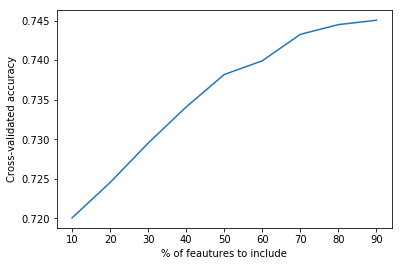

In [185]:
# plot how accuracy changes as we vary number of features
import matplotlib.pyplot as plt
%matplotlib inline

# plot the number of features (x-axis) versus the cross-validated accuracy (y-axis)
# plt.plot(x_axis, y_axis)
plt.plot(percentile_range, ufs_scores)
plt.xlabel('% of feautures to include')
plt.ylabel('Cross-validated accuracy')

We can obtain that the best threshold is at 90% percentile

In [186]:
#Setting the best model

feature_cols = X_fs.columns
selector = SelectPercentile(f_classif, percentile=90)
X_ufs_tr = selector.fit_transform(X_fs[feature_cols], y_fs)

# Get back the features we've kept, zero out all other features
selected_features = pd.DataFrame(selector.inverse_transform(X_ufs_tr), 
                                 index=X_fs.index, 
                                 columns=feature_cols)

# Dropped columns have values of all 0s, so var is 0, drop them
selected_columns = selected_features.columns[selected_features.var() != 0]
X_ufs_best=X_fs[selected_columns];


logmodel_ufs_best = LogisticRegression(random_state=444)
accuracy_ufs_best = cross_val_score(logmodel_ufs_best,
                            X_ufs_best,
                            y_fs,
                            cv=3,
                            scoring='accuracy')
print('Accuracy scores: ', accuracy_ufs_best)
print("Mean accuracy::{}".format(accuracy_ufs_best.mean()))
ufs_score_best= np.mean(accuracy_ufs_best)

Accuracy scores:  [0.74545455 0.74308081 0.74661616]
Mean accuracy::0.7450505050505051


In [187]:
#We didn't succedd to increase the model accuracy noticeably
improvement = np.round(100*(ufs_score_best - baseline_score)/baseline_score,2)
print('Overall improvement is {} %'.format(improvement))

Overall improvement is 0.08 %


### 4.3.3 Logistic Regression with regularization (L1/L2)

We will use L1/L2 regularization. Since univariate methods consider only one feature at a time when making a selection decision. Instead, we can make our selection using all of the features by including them in a linear model with regularization L1 and L2. We will use a Grid Search with cross-validation from sklearn

In [201]:
# Using Grid-Search with Cross-Validation we will choose best parameters for Lasso (L1)
from sklearn.model_selection import GridSearchCV
param_grid ={"C":np.logspace(-3,3,7), "penalty":["l1"]}# l1 
logmodel_reg_lasso=LogisticRegression()
logmodel_cv_lasso=GridSearchCV(logmodel_reg_lasso,param_grid,cv=3, scoring='accuracy')
logmodel_cv_lasso.fit(X_train,y_train)
print("hyperparameters :(best parameters) ",logmodel_cv_lasso.best_params_)
print("accuracy:",logmodel_cv_lasso.best_score_)

hyperparameters :(best parameters)  {'C': 10.0, 'penalty': 'l1'}
accuracy: 0.7442279942279942


In [202]:
# Now we will the same for Ridge (L2)
from sklearn.model_selection import GridSearchCV
param_grid ={"C":np.logspace(-3,3,7), "penalty":["l2"]}# l2
logmodel_reg_ridge=LogisticRegression()
logmodel_cv_ridge=GridSearchCV(logmodel_reg_ridge,param_grid,cv=3, scoring='accuracy')
logmodel_cv_ridge.fit(X_train,y_train)
print("hyperparameters :(best parameters) ",logmodel_cv_ridge.best_params_)
print("accuracy:",logmodel_cv_ridge.best_score_)

hyperparameters :(best parameters)  {'C': 10.0, 'penalty': 'l2'}
accuracy: 0.7429292929292929


In [207]:
#Ridge is slightly better than Lasso
regularization_score= logmodel_cv_ridge.best_score_

In [208]:
#We can seen that there is only slightly improvement with regularized regression:
improvement = np.round(100*(regularization_score - baseline_score)/baseline_score,2)
print('Overall improvement is {} %'.format(improvement))

Overall improvement is -0.2 %


None of the feature selection methods positively resulted in the accuracy improvement.
So will proceed further with intitial database and other algorithms

## 4.4 SVM (Support Vector Machines)

At this part we will try to use SVM
Also we will scale our dataset, since the method is very sensitive to not uniform scale (we will see that in a while)

In [209]:
from sklearn.preprocessing import StandardScaler
from sklearn.svm import LinearSVC

In [210]:
# Setting and fitting the model 
# It's neccessary to put the variales on the same scale, so we will use a function to see that:

def fit_predict(X_train, X_test, y_train, y_test, scaler = None):
    if scaler is None:
        svc = LinearSVC(random_state=444)
        svc.fit(X_train, y_train)
        svc_predictions =svc.predict(X_test)
        print('Accuracy score:', accuracy_score(y_test,svc_predictions))
    else:
        train_scaled = scaler.fit_transform(X_train)
        test_scaled = scaler.transform(X_test)
        svc = LinearSVC(random_state=444)
        svc.fit(train_scaled, y_train)
        svc_predictions =svc.predict(test_scaled)
        print('Accuracy score:', accuracy_score(y_test,svc_predictions))        

In [211]:
# Accuracy without Scaling
fit_predict(X_train, X_test, y_train, y_test, scaler = None)

Accuracy score: 0.40510662177328843


In [212]:
# Accuracy with StandardScaler
fit_predict(X_train, X_test, y_train, y_test, scaler = StandardScaler())

Accuracy score: 0.7418630751964085


In [213]:
#We see that the accuracy (in relation to SVM) is much better for the scaled dataset, so we decided to finally uniform it:
scaler = StandardScaler()
scaler.fit(X_dummy)
scaled_features = scaler.transform(X_dummy)
X_dummy_rescaled = pd.DataFrame(scaled_features,columns=X_dummy.columns, index=X_dummy.index)

In [214]:
svc = LinearSVC(random_state=444)
svc_scores = cross_val_score(svc, X_dummy_rescaled, y_dummy, cv=3, scoring='accuracy')
print('Accuracy scores: ', svc_scores)
print("Mean accuracy::{}".format(svc_scores.mean()))
svc_scores= np.mean(svc_scores)

Accuracy scores:  [0.74232323 0.74015152 0.74136364]
Mean accuracy::0.7412794612794612


In [215]:
#In the overall SVM performs slightly worse vs. our baseline model 
improvement = np.round(100*(svc_scores - baseline_score)/baseline_score,2)
print('Overall improvement is {} %'.format(improvement))

Overall improvement is -0.43 %


At this step we will try to play with polynomial features in SVM. Fortunately, for SVMs we can apply the kernel trick. It makes it possible to get the same result as if you added many polynomial features, even with very high degree polynomials, without actually having to add them. For this purpose we have to import SVC

After first attempts to fine-tune SVC we have found it to be extremely slow. The main reason fro this is that kernelized SVMs require the computation of a distance function between each point in the dataset, which is the dominating cost of O(nfeatures×n2observations). The storage of the distances is a burden on memory, so they're recomputed on the fly. Thankfully, only the points nearest the decision boundary are needed most of the time. Frequently computed distances are stored in a cache. If the cache is getting thrashed then the running time blows up to O(nfeatures×n3observations).

The explanation in Sklearn:

https://scikit-learn.org/stable/modules/svm.html#complexity

Below the code for searching the optimum parameters.

In general, the 'defualt' SVM showed almost the same results (slightly lower) as baseline model. Apart from that we learned that SVM only applicable to relatively small datasets for kernel optimization. 

## 4.5 KNN (Nearest Neighbor)

We will try to implement KNN on re-scaled dataset, since it is also scale-sensitive

In [216]:
#Now we will split rescaled and dummified dataset onto train and test split
X_train_rescaled, X_test_rescaled, y_train_rescaled, y_test_rescaled = train_test_split(X_dummy_rescaled, y_dummy, test_size=0.3, random_state=444)

In [217]:
from sklearn.neighbors import KNeighborsClassifier
knn = KNeighborsClassifier()
knn_scores = cross_val_score(knn, X_train_rescaled, y_train_rescaled, cv=3, scoring='accuracy')
print('Accuracy scores: ', knn_scores)
print("Mean accuracy::{}".format(knn_scores.mean()))
knn_scores= np.mean(knn_scores)

Accuracy scores:  [0.74502165 0.7465368  0.74906205]
Mean accuracy::0.7468734968734969


In [218]:
def fit_predict_knn (X_train_rescaled, X_test_rescaled, y_train_rescaled, y_test_rescaled, n_neighbors = 1):
    knn = KNeighborsClassifier(n_neighbors=n_neighbors)
    knn.fit(X_train_rescaled, y_train_rescaled)
    knn_pred = knn.predict(X_test_rescaled)
    print(accuracy_score(y_test_rescaled, knn_pred))

In [220]:
# choosing neighboors:
for n_neighbors in range(1,10,1):
    print('Accuracy score using neighboors =', n_neighbors, end = ': ')
    fit_predict_knn (X_train_rescaled, X_test_rescaled, y_train_rescaled, y_test_rescaled, n_neighbors = n_neighbors)

Accuracy score using neighboors = 1: 0.753030303030303
Accuracy score using neighboors = 2: 0.7567340067340067
Accuracy score using neighboors = 3: 0.765993265993266
Accuracy score using neighboors = 4: 0.7632996632996633
Accuracy score using neighboors = 5: 0.7643658810325477
Accuracy score using neighboors = 6: 0.7640291806958474
Accuracy score using neighboors = 7: 0.7619528619528619
Accuracy score using neighboors = 8: 0.7569584736251402
Accuracy score using neighboors = 9: 0.7551066217732885


In [224]:
#Using the best number of neighbors which is 3
knn = KNeighborsClassifier(n_neighbors=3)
knn_scores = cross_val_score(knn, X_dummy_rescaled, y_dummy, cv=3, scoring='accuracy')
print('Accuracy scores: ', knn_scores)
print("Mean accuracy::{}".format(knn_scores.mean()))
knn_scores= np.mean(knn_scores)

Accuracy scores:  [0.76444444 0.76161616 0.76252525]
Mean accuracy::0.7628619528619529


In [225]:
#KNN succeded to increase the perfomance of our model up to 3 % - not bad
improvement = np.round(100*(knn_scores - baseline_score)/baseline_score,2)
print('Overall improvement is {} %'.format(improvement))

Overall improvement is 2.47 %


The KNN is performing better that logistic regression, but it is very slow on this dataset

## 4.6 Tree-Based Methods

#### 4.6.1. Decision Tree

In [227]:
#First, we will build a tree on Rescaled data
from sklearn.tree import DecisionTreeClassifier
tree_clf_scl = DecisionTreeClassifier(random_state=444)
tree_clf_scl.fit(X_train_rescaled, y_train_rescaled)
tree_prediction_scl = tree_clf_scl.predict(X_test_rescaled)
print(accuracy_score(y_test,tree_prediction_scl))

0.7480359147025814


In [238]:
#Now we can try to build a decision tree based on original (not scaled) dataset
from sklearn.tree import DecisionTreeClassifier
tree_clf = DecisionTreeClassifier(random_state=444)
tree_clf.fit(X_train, y_train)
tree_prediction = tree_clf.predict(X_test)
print(accuracy_score(y_test,tree_prediction))

0.7493827160493827


As we can see - there is no need for scaling dataset in order to use Decision Tree Classifier

In [236]:
dt_scores = cross_val_score(tree_clf, X_dummy, y_dummy, cv=3, scoring='accuracy')
print('Accuracy scores: ', dt_scores)
print("Mean accuracy::{}".format(dt_scores.mean()))
dtcl_scores= np.mean(dt_scores)

Accuracy scores:  [0.75252525 0.74691919 0.75060606]
Mean accuracy::0.7500168350168349


In [237]:
improvement = np.round(100*(dtcl_scores - baseline_score)/baseline_score,2)
print('Overall improvement is {} %'.format(improvement))

Overall improvement is 0.75 %


Since the intitial results of Decision Tree is quite good, we will move straitforward to tree-based ensemble algorithms and try to play with the most powerful of them: RF and Light GBM - new king in the ML domain (more faster and accurate in comparison to XGBoost)

#### 4.6.2 Random Forest 

We will start with default RF model. 

In [240]:
from sklearn.ensemble import RandomForestClassifier
rfc = RandomForestClassifier(random_state=444)
rfc.fit(X_train,y_train)
predictions_rfc = rfc.predict(X_test)
print(accuracy_score(y_test,predictions_rfc))

0.7983164983164983


In [241]:
rfc_scores = cross_val_score(rfc, X_dummy, y_dummy, cv=3, scoring='accuracy')
print('Accuracy scores: ', rfc_scores)
print("Mean accuracy::{}".format(rfc_scores.mean()))
rfc_scores= np.mean(rfc_scores)

Accuracy scores:  [0.79040404 0.79267677 0.79055556]
Mean accuracy::0.7912121212121211


In [198]:
improvement = np.round(100*(rfc_scores - baseline_score)/baseline_score,2)
print('Overall improvement is {} %'.format(improvement))

Overall improvement is 6.28 %


RF improved the results significantly, so we will use it further to fine-tune the model and play with different configurations of parameters

##### RF hyperparameters fine-tuning

We will fine-tune the RF step-by-step for each parameter, since GridsearchCV would require very high computational capacity

In [199]:
#We will use a function to choose the best hyper-parameters for the model

def fit_predict(X_train, X_test, y_train, y_test,  max_depth = None , 
                n_estimators = 10, max_features = 'auto', min_samples_split = 2): 
    rfc = RandomForestClassifier(n_estimators = n_estimators, max_depth=max_depth, 
                                random_state = 444, max_features = 'auto',
                               min_samples_split = min_samples_split)
    rfc.fit(X_train,y_train)
    predictions_rfc = rfc.predict(X_test)
    print(accuracy_score(y_test,predictions_rfc))

###### Number of trees

In [200]:
#Choosing the numbers of trees in the forest:
for n_estimators in range(100,1500,100):
    print('Accuracy score using n_estimators =', n_estimators, end = ': ')
    fit_predict(X_train,X_test,y_train,y_test,n_estimators = n_estimators)

Accuracy score using n_estimators = 100: 0.8045454545454546
Accuracy score using n_estimators = 200: 0.8058361391694725
Accuracy score using n_estimators = 300: 0.8068462401795735
Accuracy score using n_estimators = 400: 0.8063973063973064
Accuracy score using n_estimators = 500: 0.8071829405162738
Accuracy score using n_estimators = 600: 0.8071268237934904
Accuracy score using n_estimators = 700: 0.8079685746352413
Accuracy score using n_estimators = 800: 0.8084175084175084
Accuracy score using n_estimators = 900: 0.807631874298541
Accuracy score using n_estimators = 1000: 0.8074074074074075
Accuracy score using n_estimators = 1100: 0.8070145903479237
Accuracy score using n_estimators = 1200: 0.8071268237934904
Accuracy score using n_estimators = 1300: 0.8074635241301908
Accuracy score using n_estimators = 1400: 0.8075196408529742


The best score is with n_estimators=800

######  Number of levels in each decision tree

In [201]:
#Max number of levels in each decision tree where we will stop splitting the nodes.
for max_depth in range(1,31,3):
    print('Accuracy score using max_depth =', max_depth, end = ': ')
    fit_predict(X_train,X_test,y_train,y_test,n_estimators = 800, max_depth = max_depth)

Accuracy score using max_depth = 1: 0.575364758698092
Accuracy score using max_depth = 4: 0.7102132435465769
Accuracy score using max_depth = 7: 0.7318742985409652
Accuracy score using max_depth = 10: 0.7557239057239057
Accuracy score using max_depth = 13: 0.7821548821548822
Accuracy score using max_depth = 16: 0.8019079685746352
Accuracy score using max_depth = 19: 0.8124579124579124
Accuracy score using max_depth = 22: 0.817003367003367
Accuracy score using max_depth = 25: 0.8143097643097643
Accuracy score using max_depth = 28: 0.8120089786756454


The best score is with n_estimators=800 and max_depth=22

###### Min samples split

In [202]:
#Min number of data points placed in a node before the node is split
for min_samples_split in range(2,6):
    print('Accuracy score using min_samples_split =', min_samples_split, end = ': ')
    fit_predict(X_train,X_test,y_train,y_test, n_estimators = 800, max_depth = 22, min_samples_split=min_samples_split)

Accuracy score using min_samples_split = 2: 0.817003367003367
Accuracy score using min_samples_split = 3: 0.8170594837261503
Accuracy score using min_samples_split = 4: 0.8168911335578002
Accuracy score using min_samples_split = 5: 0.8151515151515152


The best score is with n_estimators=800, max_depth=22 and min_samples_split=3

In [232]:
print('RF intitial accuracy score', end = ': ')
fit_predict(X_train,X_test,y_train,y_test)
print('RF tuned accuracy score', end = ': ')
fit_predict(X_train,X_test,y_train,y_test, n_estimators = 800, max_depth = 22, min_samples_split=3)

RF intitial accuracy score: 0.7983164983164983
RF tuned accuracy score: 0.8170594837261503


In [242]:
#Cross-validating the model results on the whole dataset by the means of 3 CV folds
from sklearn.model_selection import cross_val_score
rfc_best = RandomForestClassifier(random_state=444, n_estimators = 800, max_depth = 22, min_samples_split=3)
accuracy_rfc_best = cross_val_score(rfc_best,
                            X_dummy,
                            y_dummy,
                            cv=3,
                            scoring='accuracy')
print('Accuracy scores: ', accuracy_rfc_best)
print("Mean accuracy::{}".format(accuracy_rfc_best.mean()))

Accuracy scores:  [0.81171717 0.81383838 0.81121212]
Mean accuracy::0.8122558922558922


In [243]:
#Saving the best model for fitting the unseen data
from sklearn.ensemble import RandomForestClassifier
rfc_best.fit(X_train,y_train)
predictions_rfc_best = rfc_best.predict(X_test)
print(accuracy_score(y_test,predictions_rfc_best))

0.8170594837261503


In [245]:
#With fine-tuned RF we succeded to improve the model significantly
best_rfc_scores= np.mean(accuracy_rfc_best)
improvement = np.round(100*(best_rfc_scores - baseline_score)/baseline_score,2)
print('Overall improvement is {} %'.format(improvement))

Overall improvement is 9.11 %


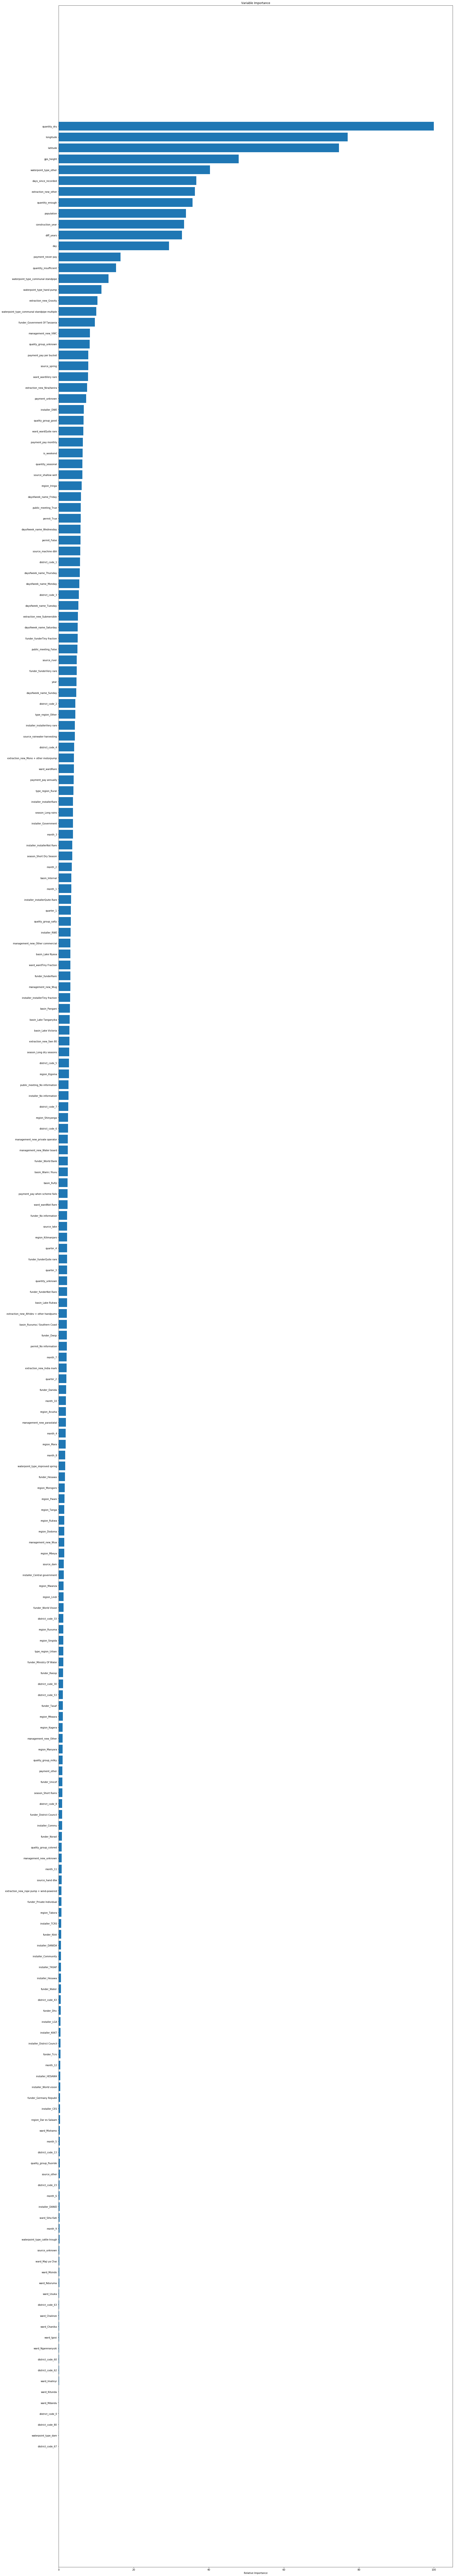

In [246]:
#Let take a look at the feature importance:
feature_importance = rfc_best.feature_importances_
feature_importance = 100.0 * (feature_importance / feature_importance.max())
sorted_idx = np.argsort(feature_importance)
pos = np.arange(sorted_idx.shape[0]) + 0.5
plt.figure(figsize=(30, 200))
plt.barh(pos, feature_importance[sorted_idx], align="center")
plt.yticks(pos, X_train.columns[sorted_idx])
plt.xlabel("Relative Importance")
plt.title("Variable Importance")
plt.show()

By analyzing the importance of parameters we can see that  GEOparameters (longtitude/latitude/gps_height) are the most crucial for prediction. But the main factor - quantity of the water

### 4.6.3 Light GBM

LightGBM is a gradient boosting framework that uses tree-based algorithms and follows leaf-wise approach while other algorithms work in a level-wise approach pattern. Light GBM beats all the other algorithms when the dataset is extremely large. Compared to the other algorithms, Light GBM takes lesser time to run on a huge dataset. LightGBM provides a fast and simple implementation of the GBM in Python.

In [247]:
#!pip install lightgbm 
from lightgbm import LGBMClassifier
import lightgbm as lgb

In [248]:
lgbm = LGBMClassifier(random_state=444)
lgbm.fit(X_train, y_train)
lgbm_pred = lgbm.predict(X_test)
print(accuracy_score(y_test,lgbm_pred))

0.7875420875420875


In [204]:
#The default parameters
lgbm

LGBMClassifier(boosting_type='gbdt', class_weight=None, colsample_bytree=1.0,
               importance_type='split', learning_rate=0.1, max_depth=-1,
               min_child_samples=20, min_child_weight=0.001, min_split_gain=0.0,
               n_estimators=100, n_jobs=-1, num_leaves=31, objective=None,
               random_state=444, reg_alpha=0.0, reg_lambda=0.0, silent=True,
               subsample=1.0, subsample_for_bin=200000, subsample_freq=0)

There are a lot of hyperparameters to optimize!
We will look at the official documention and decide which parameters to start with.

https://lightgbm.readthedocs.io/en/latest/Parameters-Tuning.html


We will follow the advice for accuracy increase from official documentation

#### Light GBM hyperparameters tuning

In [255]:
#We will use a function to choose the best hyper-parameters for the model

def fit_predict_lgb (X_train, X_test, y_train, y_test, boosting_type='dart', max_bin=300, learning_rate=0.2, num_iterations =100, num_leaves =100):    
    lgbm = LGBMClassifier(random_state=444, boosting_type='dart',max_bin=max_bin, learning_rate=learning_rate, num_iterations=num_iterations, num_leaves=num_leaves)
    lgbm.fit(X_train, y_train)
    lgbm_pred = lgbm.predict(X_test)
    print(accuracy_score(y_test,lgbm_pred))

In [256]:
#Max bin
for max_bin in range (50, 501, 50):
    print('Accuracy score using max_bin =', max_bin, end = ': ')
    fit_predict_lgb(X_train,X_test,y_train,y_test, max_bin=max_bin)

Accuracy score using max_bin = 50: 0.7992143658810326
Accuracy score using max_bin = 100: 0.8007856341189674
Accuracy score using max_bin = 150: 0.8010101010101011
Accuracy score using max_bin = 200: 0.8012345679012346
Accuracy score using max_bin = 250: 0.801290684624018
Accuracy score using max_bin = 300: 0.8031986531986532
Accuracy score using max_bin = 350: 0.8032547699214366
Accuracy score using max_bin = 400: 0.80331088664422
Accuracy score using max_bin = 450: 0.8011784511784512
Accuracy score using max_bin = 500: 0.8015151515151515


In [257]:
#learning_rate
for learning_rate in[0.001,0.01,0.05,0.1,0.15,0.2,0.25,0.3]:
    print('Accuracy score using learning_rate =', learning_rate, end = ': ')
    fit_predict_lgb(X_train,X_test,y_train,y_test,  max_bin=400, learning_rate = learning_rate)

Accuracy score using learning_rate = 0.001: 0.5422558922558922
Accuracy score using learning_rate = 0.01: 0.7593714927048261
Accuracy score using learning_rate = 0.05: 0.7796857463524131
Accuracy score using learning_rate = 0.1: 0.7920314253647587
Accuracy score using learning_rate = 0.15: 0.7978675645342312
Accuracy score using learning_rate = 0.2: 0.80331088664422
Accuracy score using learning_rate = 0.25: 0.8040965207631874
Accuracy score using learning_rate = 0.3: 0.8054994388327722


In [259]:
#Number iterations
for num_iterations in range (100, 701, 100):
    print('Accuracy score using num_iterations =', num_iterations, end = ': ')
    fit_predict_lgb(X_train,X_test,y_train,y_test, max_bin=400, learning_rate = 0.3, num_iterations=num_iterations)

Accuracy score using num_iterations = 100: 0.8054994388327722
Accuracy score using num_iterations = 200: 0.8107744107744108
Accuracy score using num_iterations = 300: 0.8124579124579124
Accuracy score using num_iterations = 400: 0.8121212121212121
Accuracy score using num_iterations = 500: 0.811952861952862
Accuracy score using num_iterations = 600: 0.811391694725028
Accuracy score using num_iterations = 700: 0.8103254769921436


In [260]:
#Num of leaves
for num_leaves in range (50, 501, 50):
    print('Accuracy score using num_leaves =', num_leaves, end = ': ')
    fit_predict_lgb(X_train,X_test,y_train,y_test, max_bin=400, learning_rate = 0.3, num_iterations=300, num_leaves=num_leaves)

Accuracy score using num_leaves = 50: 0.8079124579124579
Accuracy score using num_leaves = 100: 0.8124579124579124
Accuracy score using num_leaves = 150: 0.8130190796857464
Accuracy score using num_leaves = 200: 0.809652076318743
Accuracy score using num_leaves = 250: 0.8080808080808081
Accuracy score using num_leaves = 300: 0.808361391694725
Accuracy score using num_leaves = 350: 0.807631874298541
Accuracy score using num_leaves = 400: 0.807631874298541
Accuracy score using num_leaves = 450: 0.8061728395061728
Accuracy score using num_leaves = 500: 0.805331088664422


In [249]:
lgbm_best = LGBMClassifier(random_state=444, boosting_type='dart', max_bin=400, learning_rate = 0.3, num_iterations=300, num_leaves=130)
lgbm_best.fit(X_train, y_train)
lgbm_best_pred = lgbm_best.predict(X_test)
print(accuracy_score(y_test,lgbm_best_pred))

0.8136363636363636


In [250]:
#Cross-validating the model results on the whole dataset by the means of 3 CV folds
accuracy_lgbm_best= cross_val_score(lgbm_best,
                            X_dummy,
                            y_dummy,
                            cv=3,
                            scoring='accuracy')
print('Accuracy scores: ', accuracy_lgbm_best)
print("Mean accuracy::{}".format(accuracy_lgbm_best.mean()))

Accuracy scores:  [0.80808081 0.80787879 0.80808081]
Mean accuracy::0.808013468013468


In [251]:
#With LGBM we succeded to furthermore increase the accuracy 
lgbm_best_score= np.mean(accuracy_lgbm_best)
improvement = np.round(100*(lgbm_best_score - baseline_score)/baseline_score,2)
print('Overall improvement is {} %'.format(improvement))

Overall improvement is 8.54 %


# 5. Models optimization (ensembling different learners using MaxVoting and Stacking techniques)

## 5.1. Max Voting

In this technique, multiple models are used to make predictions for each data point. The predictions by each model are considered as a ‘vote’. The predictions which we get from the majority of the models are used as the final prediction.

For MaXvoting approach we could futher improving the simple Desicision Tree by tuning the hyperparameters or using boosting algorithm (in particular Adaptive boosting) 

AdaBoost is one of the simplest boosting algorithms. It assigns weights to the observations which are incorrectly predicted and the subsequent model works to predict these values correctly. Multiple sequential models are created, each correcting the errors from the last model. 

In [255]:
# We will put default Decisions Tree classifier inside the AdaBoost
from sklearn.ensemble import AdaBoostClassifier
ada_clf = AdaBoostClassifier(DecisionTreeClassifier(random_state=444))
ada_clf.fit(X_train, y_train)
ada_prediction = ada_clf.predict(X_test)
print(accuracy_score(y_test,ada_prediction))

0.7883838383838384


In [257]:
from sklearn.ensemble import VotingClassifier
model1 = ada_clf
model2 = rfc_best
model3 = lgbm_best
voting_model = VotingClassifier(estimators=[('ada_boost', model1), ('rfc_best', model2), ('lgbm', model3)], voting='hard')
voting_model.fit(X_train,y_train)
predictions_voting_model = voting_model.predict(X_test)
print(accuracy_score(y_test,predictions_voting_model))

0.8167789001122334


In [259]:
#Cross-validating the model results on the whole dataset by the means of 3 CV folds
accuracy_voting= cross_val_score(voting_model,
                            X_dummy,
                            y_dummy,
                            cv=3,
                            scoring='accuracy')
print('Accuracy scores: ', accuracy_voting)
print("Mean accuracy::{}".format(accuracy_voting.mean()))

Accuracy scores:  [0.81121212 0.81419192 0.81161616]
Mean accuracy::0.8123400673400673


In [260]:
#Using MaxVoting we succeded to furthermore increase the accuracy 
maxvoting_score= np.mean(accuracy_voting);
improvement = np.round(100*(maxvoting_score - baseline_score)/baseline_score,2)
print('Overall improvement is {} %'.format(improvement))

Overall improvement is 9.12 %


## 5.2. Stacking

In [276]:
from mlxtend.classifier import StackingClassifier
from sklearn import model_selection

In [309]:
y_train_st=y_train
y_test_st=y_test
y_st=y_dummy;

In [317]:
#For Stacking implementation we have to transform the target labels into numbers
target = {'functional': 1, 'non functional': 2, 'functional needs repair':3} 

In [ ]:
y_train_st=y_train_st.map(target);
y_test_st=y_test_st.map(target);
y_st = y_st.map(target);

In [306]:
#Initializing the 1-st level models and meta-Classifier

sclf = StackingClassifier(classifiers=[ada_clf,rfc_best, lgbm_best], 
                          meta_classifier=RandomForestClassifier())


for clf, label in zip([ada_clf,rfc_best, lgbm_best, sclf], 
                      ['DT', 
                       'Random Forest', 
                       'LGBM',
                       'StackingClassifier']):

    scores = model_selection.cross_val_score(clf, X_train, y_train_st, 
                                              cv=3, scoring='accuracy')
    print("Accuracy: %0.2f (+/- %0.2f) [%s]" 
          % (scores.mean(), scores.std(), label))

Accuracy: 0.78 (+/- 0.01) [DT]
Accuracy: 0.80 (+/- 0.00) [Random Forest]
Accuracy: 0.80 (+/- 0.00) [LGBM]
Accuracy: 0.78 (+/- 0.01) [StackingClassifier]


In [321]:
#Cross-validating the model results on the whole dataset by the means of 3 CV folds
accuracy_stacking= cross_val_score(sclf,
                            X_dummy,
                            y_st,
                            cv=3,
                            scoring='accuracy')
print('Accuracy scores: ', accuracy_stacking)
print("Mean accuracy::{}".format(accuracy_stacking.mean()))

Accuracy scores:  [0.78808081 0.78964646 0.78378788]
Mean accuracy::0.7871717171717171


In [322]:
stacking_score= np.mean(accuracy_stacking);
improvement = np.round(100*(stacking_score - baseline_score)/baseline_score,2)
print('Overall improvement is {} %'.format(improvement))

Overall improvement is 5.74 %


As we can see we didn't make any improvement with the usage of stacking

# 6. Models comparison and best prediction

### Models comparison

In [340]:
print("Logistic Regression - Baseline Model")
print("Accuracy: %.3f" % baseline_score)
print("")
print("Logistic Regression  - using ExtraTreesRegressor")
print("Accuracy: %.3f" % impt1_score)
print("")
print("Logistic Regression - after removing features with Low Variance Threshold")
print("Accuracy: %.3f" % best_vt_score)
print("")
print("Logistic Regression - after univariate feautures selection with ANOVA test")
print("Accuracy: %.3f" % ufs_score_best)
print("")
print("Logistic Regression with Regularization  (Ridge)")
print("Accuracy: %.3f" % regularization_score)
print("")
print("SVM")
print("Accuracy: %.3f" % svc_scores)
print("")
print("KNN")
print("Accuracy: %.3f" % knn_scores)
print("")
print("Decision Tree")
print("Accuracy: %.3f" % dtcl_scores)
print("")
print("Random Forest")
print("Accuracy: %.3f" % best_rfc_scores)
print("")
print("Light GBM")
print("Accuracy: %.3f" % lgbm_best_score)
print("")
print("MaxVoting with Tree Based Models")
print("Accuracy: %.3f" % maxvoting_score)
print("")
print("Stacking with Tree Based Models")
print("Accuracy: %.3f" % stacking_score)

Logistic Regression - Baseline Model
Accuracy: 0.744

Logistic Regression  - using ExtraTreesRegressor
Accuracy: 0.744

Logistic Regression - after removing features with Low Variance Threshold
Accuracy: 0.696

Logistic Regression - after univariate feautures selection with ANOVA test
Accuracy: 0.745

Logistic Regression with Regularization  (Ridge)
Accuracy: 0.743

SVM
Accuracy: 0.741

KNN
Accuracy: 0.763

Decision Tree
Accuracy: 0.750

Random Forest
Accuracy: 0.812

Light GBM
Accuracy: 0.808

MaxVoting with Tree Based Models
Accuracy: 0.812

Stacking with Tree Based Models
Accuracy: 0.787


The best models we got was achieved by Random Forest and MaxVoting techniques with 0.812 of accuracy (by means of 3 folds CV).

Since they record almost equal scores, we will see further if any of them is over-fitting the data (gain higher Train and worse Test scores)

In [338]:
print('Random Forest Classifier Train Accuracy Score :', rfc_best.score(X_train, y_train))
print('Random Forest Classifier Test Score :', rfc_best.score(X_test, y_test))

Random Forest Classifier Train Accuracy Score : 0.9325156325156325
Random Forest Classifier Test Score : 0.8170594837261503


In [339]:
print('MaxVoting Train Accuracy Score :', voting_model.score(X_train, y_train))
print('MaxVoting Test Score :', voting_model.score(X_test, y_test))

MaxVoting Train Accuracy Score : 0.9536075036075036
MaxVoting Test Score : 0.8167789001122334


So looks like its the case of MaxVoting, so finally we have choosen Random Forest for our prediction

## Predicting on Unseen data 

In [327]:
X_unseen=X.iloc[59400:,]

In [328]:
predictions_unseen=rfc_best.predict(X_unseen)

In [329]:
predictions_fin=pd.Series(predictions_unseen)

## Submission

In [330]:
# Save the predictions in form of a dataframe
submission = pd.DataFrame()
submission['id'] = np.array(df_test['id'])
submission['status_group'] = predictions_fin

In [274]:
#submission.to_csv('C:/Users/serge/Desktop/submission.csv', index=False) 0.8203 accuracy at DataDriven (Rank 504)


# 7.  Possible Additional Improvements

As GEOparameters are the most crucial for prediction we should think about  more advanced imputation of incorrect spatial data.
Also we could gather the exact population data from external sources and add it to our dataset, and check if the population in particular areas is affecting the functional status of the pump, which can help them to predict the areas and take more care in that area.
We can identify the life time of a pump by using the historical data, which could help the Tanzanian water ministry to help them repair them before they get non-functional.